In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_tcell.rv1'

# Set data info
DS_LIST = ['tms_facs']
DIC_INFO = {}
DIC_INFO['tms_facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['tms_droplet'] = {'species': 'mmusculus', 'dname': 'TMS droplet'}
DIC_INFO['ts_facs'] = {'species': 'hsapiens', 'dname': 'TS FACS'}
DIC_INFO['canogamez'] = {'species': 'hsapiens', 'dname': 'Cano-Gamez & Soskic et al.'}
DIC_INFO['nathan'] = {'species': 'hsapiens', 'dname': 'Nathan et al.'}

# Set score file
DIC_SCORE_PATH = {'tms_facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore',
                  'tms_facs.tsig': DATA_PATH+'/score_file/score.tms_facs_with_cov.tcell_sig',
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['tms_facs'] = [
    'PASS_IBD_deLange2017', 'PASS_CD_deLange2017','PASS_UC_deLange2017', 'PASS_Rheumatoid_Arthritis', 
    'PASS_Multiple_sclerosis', 'UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 
    'UKB_460K.disease_RESPIRATORY_ENT', 'UKB_460K.body_HEIGHTz'
]
DIC_TRAIT_LIST['tms_facs.tsig'] = [
    'naive_cd4', 'memory_cd4', 'effector_cd4', 'naive_cd8', 'memory_cd8', 'effector_cd8'
]

# Add T cell signatures to DF_TRAIT_INFO
temp_dic = {
    'naive_cd4':'Naive CD4', 'memory_cd4':'Memory CD4', 'effector_cd4':'Effector CD4',
    'naive_cd8':'Naive CD8', 'memory_cd8':'Memory CD8', 'effector_cd8':'Effector CD8'
}
for trait in temp_dic:
    DF_TRAIT_INFO.loc[trait, ['Trait_Identifier', 'Code']] = [trait, temp_dic[trait]]

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['tms_facs'] = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['tms_facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/single_cell_data/'
                                      'tms_proc/tcell.facs.annot.h5ad')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = sorted(set(dic_data_proc[ds].obs_names) & set(dic_score[ds].index))

In [5]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.full_score.gz'%trait
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            dic_ctrl_score[score][trait] = temp_df.loc[dic_cell_list[ds]].copy()
        else:
            print('# missing: %s'%file_path)

# Loading tms_facs PASS_IBD_deLange2017
# Loading tms_facs PASS_CD_deLange2017
# Loading tms_facs PASS_UC_deLange2017
# Loading tms_facs PASS_Rheumatoid_Arthritis
# Loading tms_facs PASS_Multiple_sclerosis
# Loading tms_facs UKB_460K.disease_AID_ALL
# Loading tms_facs UKB_460K.disease_HYPOTHYROIDISM_SELF_REP
# Loading tms_facs UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED
# Loading tms_facs UKB_460K.disease_ASTHMA_DIAGNOSED
# Loading tms_facs UKB_460K.disease_RESPIRATORY_ENT
# Loading tms_facs UKB_460K.body_HEIGHTz
# Loading tms_facs.tsig naive_cd4
# Loading tms_facs.tsig memory_cd4
# Loading tms_facs.tsig effector_cd4
# Loading tms_facs.tsig naive_cd8
# Loading tms_facs.tsig memory_cd8
# Loading tms_facs.tsig effector_cd8


### UMAP for all T cells 

n_tissue=15, BAT,Brain_Non-Myeloid,Diaphragm,GAT,Heart,Kidney,Limb_Muscle,Liver,Lung,MAT,Marrow,SCAT,Skin,Spleen,Trachea


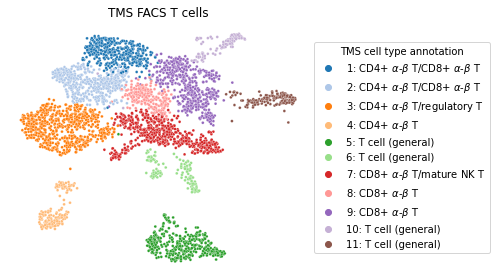

In [6]:
adata = dic_data_proc['tms_facs'].copy()
tissue_list = sorted(adata.obs['tissue'].unique())
print('n_tissue=%d, %s'%(len(tissue_list), ','.join(tissue_list)))
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]}, dtype=float)
df_plot = df_plot.join(adata.obs[['leiden_reorder', 'leiden_anno']])
df_plot['label'] = ['%s: %s'%(x,y) for x,y in zip(df_plot['leiden_reorder'], df_plot['leiden_anno'])]
df_plot['label'] = df_plot['label'].astype('category')

hue_list = []
for x in df_plot['leiden_reorder'].cat.categories:
    for y in set(df_plot['label']):
        if y.startswith('%s: '%x):
            hue_list.append(y)

plt.figure(figsize=[7,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='label', s=8, palette='tab20', hue_order=hue_list)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title="TMS cell type annotation")
plt.title('TMS FACS T cells')
plt.tight_layout()
plt.savefig(FIG_PATH+'/tcell_tms_annot_umap.svg')
plt.show()

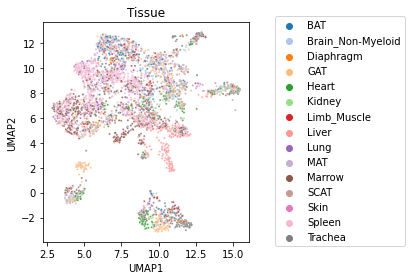

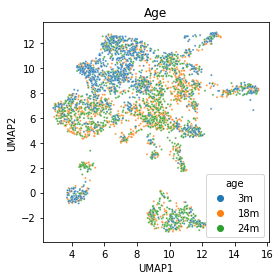

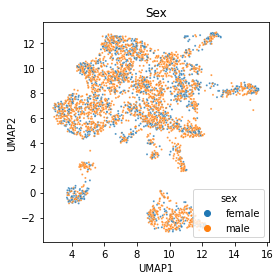

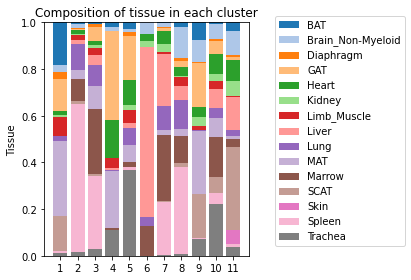

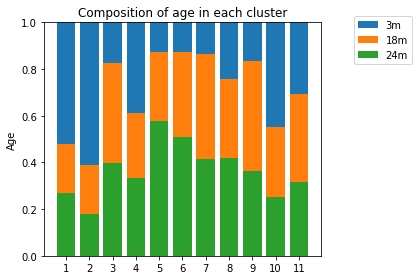

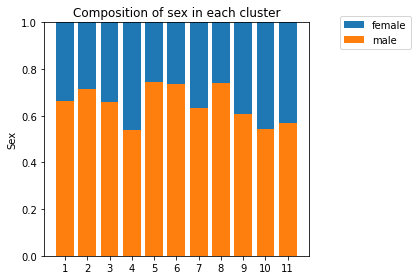

In [7]:
# Covariate composition UMAP
df_plot = pd.DataFrame(index=adata.obs_names, data={'UMAP1':adata.obsm['X_umap'][:,0],
                                                    'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['tissue', 'age', 'sex']])

for col in ['tissue', 'age', 'sex']:
    palette = 'tab20' if col=='tissue' else 'tab10'
    plt.figure(figsize=[4+2*(col=='tissue'),4])
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', palette=palette, hue=col, s=4, alpha=0.8)
    plt.title(col.capitalize())
    if col=='tissue':
        plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/tcell_tms_cov_%s.umap.svg'%col)
    plt.savefig(FIG_PATH+'/tcell_tms_cov_%s.umap.png'%col)
    plt.show()
    
# Covariate composition 
df_plot = adata.obs.copy()
df_plot['label'] = ['%s: %s'%(x,y) for x,y in zip(df_plot['leiden_reorder'], df_plot['leiden_anno'])]
df_plot['label'] = df_plot['label'].astype('category')
cluster_list = sorted(set(df_plot['leiden_reorder']))
for col in ['tissue', 'age', 'sex']:
    cmap = matplotlib.cm.get_cmap('tab20') if col=='tissue' else matplotlib.cm.get_cmap('tab10')
    term_list = sorted(set(df_plot[col]))
    if col == 'age':
        term_list = ['3m', '18m', '24m']
    plt.figure(figsize=[6,4])
    v_y = np.ones(len(cluster_list))
    for i_term,term in enumerate(term_list):
        v_y_dif = np.array([(df_plot.loc[df_plot['leiden_reorder']==x, col]==term).mean() for x in cluster_list])
        plt.bar(cluster_list, v_y_dif, bottom=v_y-v_y_dif, label=term, color=cmap(i_term))
        v_y = v_y-v_y_dif
    plt.xticks(cluster_list, cluster_list)
    plt.ylabel(col.capitalize())
    plt.ylim([0,1])
    plt.title('Composition of %s in each cluster'%col)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/tcell_tms_cov_%s.bar.svg'%col)
    plt.show()

### Subpolulation of associated cells 

In [8]:
# Get adata and association labels
ds,score = 'tms_facs','tms_facs'

# Get adata_assoc
adata_assoc = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata_assoc.obs = adata_assoc.obs.join(temp_adata.obs[
    [x for x in temp_adata.obs.columns if x not in adata_assoc.obs.columns]
])
adata_assoc.obsm = temp_adata.obsm.copy()
adata_assoc.obs['leiden_reorder'] = [str(x) for x in adata_assoc.obs['leiden_reorder']]
del temp_adata
        
# Add cell cycle S_score and G2M_score : proliferation
cc_genes = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/'
                       'Macosko_cell_cycle_genes.txt', sep='\t')
s_genes = [DIC_MAP_H2M[x] for x in cc_genes['S'] if x in DIC_MAP_H2M]
s_genes = list(set(s_genes) & set(adata_assoc.var_names))
g2m_genes = [DIC_MAP_H2M[x] for x in cc_genes['G2.M'] if x in DIC_MAP_H2M]
g2m_genes = list(set(g2m_genes) & set(adata_assoc.var_names))
sc.tl.score_genes_cell_cycle(adata_assoc, s_genes=s_genes, g2m_genes=g2m_genes)

# Define signifincant populations
dic_sig_group = {}
dic_top_group = {}
adata_assoc.obs = adata_assoc.obs.join(dic_score[score][['%s.fdr'%x for x in DIC_TRAIT_LIST[ds]]])
adata_assoc.obs = adata_assoc.obs.join(dic_score[score][['%s.norm_score'%x for x in DIC_TRAIT_LIST[ds]]])
for trait in DIC_TRAIT_LIST[ds]:
    # 'leiden_sig_full.{trait}' : leiden for significant cells (FDR<0.1)
    # 'leiden_sig.{trait}' : leiden for significant cells (FDR<0.1) in major clusters (>25 sig. cells)
    adata_assoc.obs['leiden_sig_full.%s'%trait] = [
        '%s.sig'%x if y<0.1 else 'nonsig' 
        for x,y in zip(adata_assoc.obs['leiden_reorder'], adata_assoc.obs['%s.fdr'%trait])
    ]
    
    adata_assoc.obs['leiden_sig.%s'%trait] = adata_assoc.obs['leiden_sig_full.%s'%trait].copy()
    temp_df = adata_assoc.obs.groupby(['leiden_sig.%s'%trait]).agg({'cell':len})
    cluster_removal_list = list(temp_df.index[temp_df['cell']<25]) #+ ['10.sig']
    ind_remove = adata_assoc.obs['leiden_sig.%s'%trait].isin(cluster_removal_list)
    adata_assoc.obs.loc[ind_remove, 'leiden_sig.%s'%trait] = 'nonsig' 
    
    # dic_sig_group : all leiden_sig groups
    # dic_top_group : top 4 leiden_sig groups
    dic_sig_group[trait] = [
        int(x.replace('.sig','')) for x in adata_assoc.obs['leiden_sig.%s'%trait].unique() if '.sig' in x]
    dic_sig_group[trait] = ['%d.sig'%x for x in sorted(dic_sig_group[trait])]
    
    temp_df = adata_assoc.obs.groupby('leiden_sig.%s'%trait).agg({'%s.norm_score'%trait:np.mean})
    temp_df.drop('nonsig', inplace=True)
    dic_top_group[trait] = temp_df.sort_values('%s.norm_score'%trait, ascending=False).index[:4]
    dic_top_group[trait] = [x for x in dic_sig_group[trait] if x in dic_top_group[trait]]
    
    # Do a summary here ... 
    print('|{:^8s}|{:^20s}|{:^80s}|'.format(
        DF_TRAIT_INFO.loc[trait, 'Code'], 
        'n_sig = %4d/%d'%((adata_assoc.obs['%s.fdr'%trait]<0.1).sum(), adata_assoc.shape[0]),
        ', '.join(['%s %d/%d'%(x, (adata_assoc.obs['leiden_sig.%s'%trait]==x).sum(), 
                                (adata_assoc.obs['leiden_reorder']==x.split('.')[0]).sum())
                  for x in dic_top_group[trait]])
    ))
#     display(temp_df.sort_values('%s.norm_score'%trait, ascending=False))

|  IBD   | n_sig =  387/3769  |            3.sig 123/629, 4.sig 78/165, 5.sig 85/370, 9.sig 41/499             |
|   CD   | n_sig =  237/3769  |                    3.sig 54/629, 4.sig 53/165, 5.sig 51/370                    |
|   UC   | n_sig =   25/3769  |                                                                                |
|   RA   | n_sig = 1517/3769  |           1.sig 156/402, 3.sig 342/629, 4.sig 52/165, 9.sig 272/499            |
|   MS   | n_sig =  887/3769  |            3.sig 146/629, 4.sig 41/165, 5.sig 96/370, 9.sig 141/499            |
|  AIT   | n_sig = 1638/3769  |           3.sig 445/629, 4.sig 74/165, 5.sig 189/370, 9.sig 284/499            |
|   HT   | n_sig = 1484/3769  |           3.sig 449/629, 4.sig 63/165, 9.sig 258/499, 10.sig 44/112            |
| Eczema | n_sig =  924/3769  |           1.sig 103/402, 3.sig 287/629, 4.sig 82/165, 5.sig 132/370            |
|  ASM   | n_sig =  892/3769  |           3.sig 200/629, 4.sig 77/165, 5.sig 161/370, 9.sig 127/

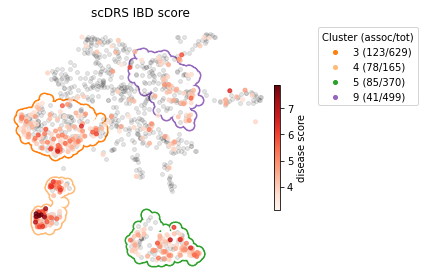

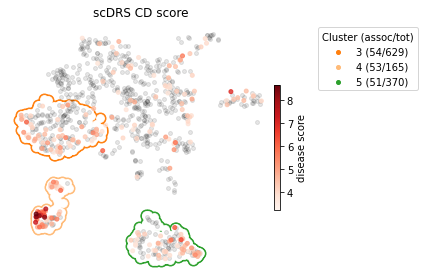

No handles with labels found to put in legend.


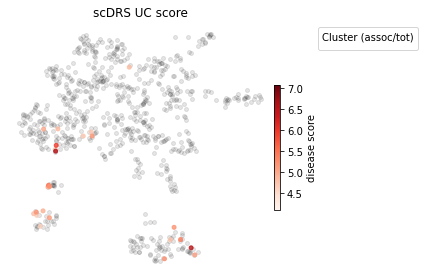

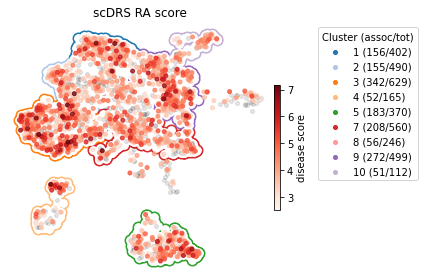

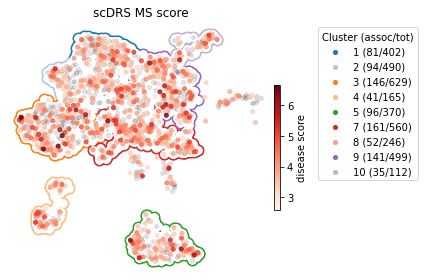

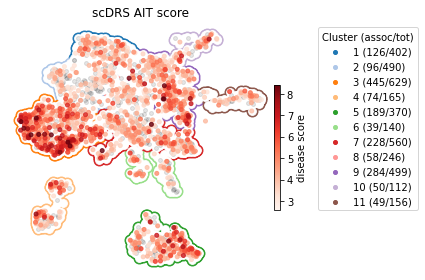

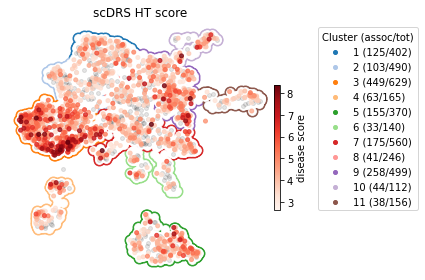

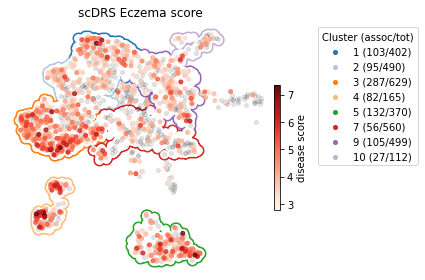

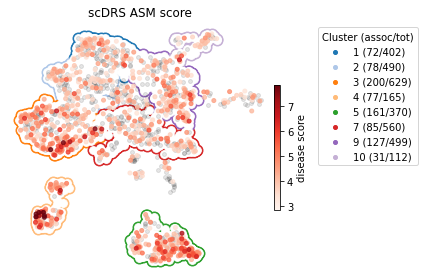

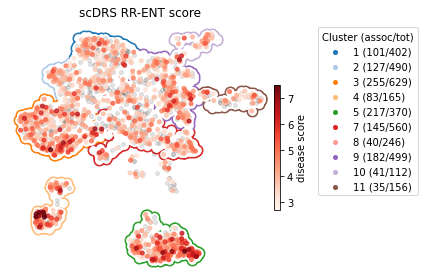

No handles with labels found to put in legend.


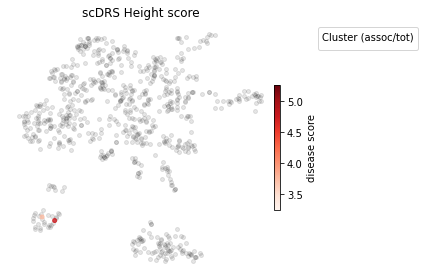

In [9]:
# UMAP for all traits
cmap = matplotlib.cm.get_cmap('tab20')
for trait in DIC_TRAIT_LIST[ds]:    
    # Get df_plot 
    df_plot = pd.DataFrame(index=adata_assoc.obs_names, 
                           data={'UMAP1':adata_assoc.obsm['X_umap'][:,0],
                                 'UMAP2':adata_assoc.obsm['X_umap'][:,1]})
    df_plot = df_plot.join(adata_assoc.obs[
        ['leiden_reorder', 'cell', 
         '%s.fdr'%trait, '%s.norm_score'%trait, 'leiden_sig.%s'%trait, 'leiden_sig_full.%s'%trait]
    ])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)
    dic_config = {x:['%s @a'%x.split('.')[0]] for x in dic_sig_group[trait]}
   
    # Figure 
    plt.figure(figsize=[6,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')

    # Cluster boundry 
    x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
    y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
    for cluster in dic_sig_group[trait]:
        ind_select = df_plot['leiden_reorder']==cluster.split('.')[0]
        assoc_str = '(%d/%d)'%((ind_select&(df_plot['leiden_sig.%s'%trait]!='nonsig')).sum(), ind_select.sum())
        temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
        xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
        xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
        ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
        ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
        ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                        (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                    s=16, color=cmap(int(cluster.split('.')[0])-1),
                    label=dic_config[cluster][0].replace('@a',assoc_str), zorder=0)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=120, color=cmap(int(cluster.split('.')[0])-1), zorder=1)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=60, color='w', zorder=2)
    
    # Grey for non-sig cells 
    np.random.seed(0)
    ind_select_sig = (df_plot['leiden_sig_full.%s'%trait]!='nonsig')
    cell_list_nonsig = np.random.choice(
        df_plot.index[~ind_select_sig], size=int((~ind_select_sig).sum()*0.2), replace=False)
    plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)
    
    # Red for sig cells 
    vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
                c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
                cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
    plt.colorbar(shrink=0.5, pad=0, label='disease score')
    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', title='Cluster (assoc/tot)')
    plt.title('scDRS %s score'%DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(score, trait))
    plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.png'%(score, trait))
    plt.show()

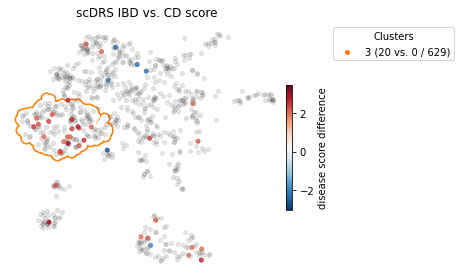

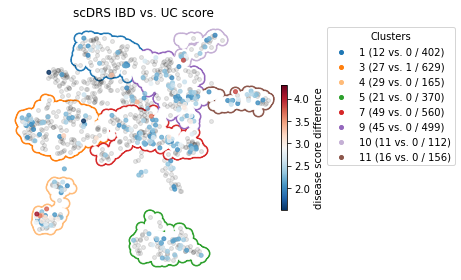

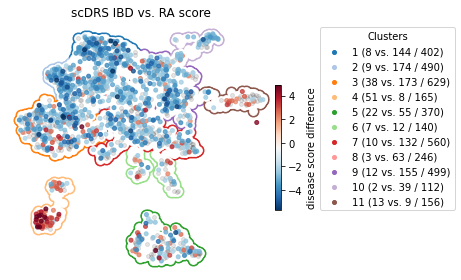

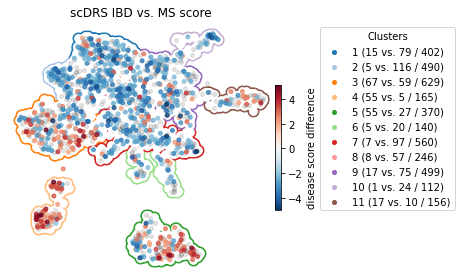

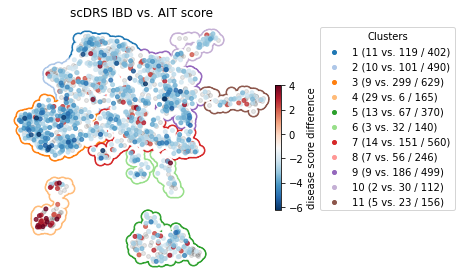

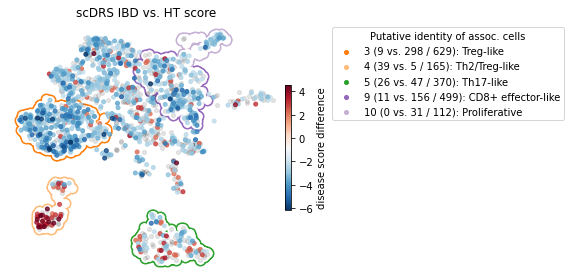

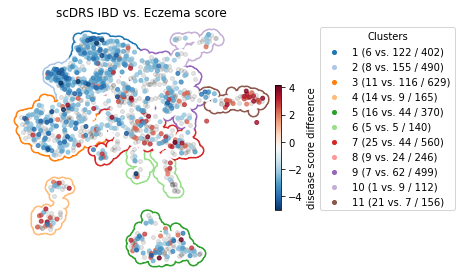

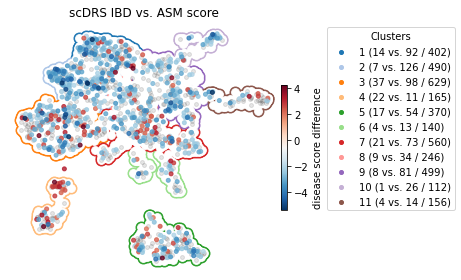

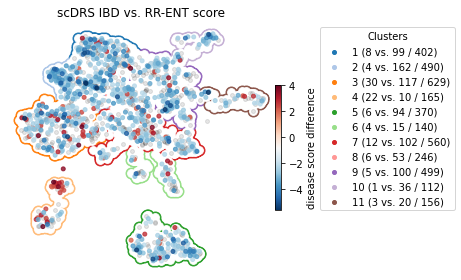

In [10]:
# UMAP for score differences of IBD vs. other pairs
def num2str(x):
    return '%d'%x if x>=25 else '-'
cmap = matplotlib.cm.get_cmap('tab20')

trait1 = 'PASS_IBD_deLange2017'

for trait2 in DIC_TRAIT_LIST['tms_facs']:
    if trait2 in ['PASS_IBD_deLange2017', 'UKB_460K.body_HEIGHTz']:
        continue
    # Get df_plot 
    df_plot = pd.DataFrame(index=adata_assoc.obs_names, 
                           data={'UMAP1':adata_assoc.obsm['X_umap'][:,0],
                                 'UMAP2':adata_assoc.obsm['X_umap'][:,1]})
    df_plot = df_plot.join(adata_assoc.obs[
        ['leiden_reorder', 'cell', '%s.norm_score'%trait1, '%s.norm_score'%trait2]
    ])
    df_plot['norm_score_dif'] = df_plot['%s.norm_score'%trait1] - df_plot['%s.norm_score'%trait2]
    df_plot['abs_norm_score_dif'] = np.absolute(df_plot['norm_score_dif'])
    df_plot.sort_values('abs_norm_score_dif', ascending=True, inplace=True)

    df_plot['leiden_sig1'] = ['%s.sig'%x if y>2 else 'nonsig'
                              for x,y in zip(df_plot['leiden_reorder'], df_plot['norm_score_dif'])]
    df_plot['leiden_sig2'] = ['%s.sig'%x if y<-2 else 'nonsig'
                              for x,y in zip(df_plot['leiden_reorder'], df_plot['norm_score_dif'])]
    df_plot['leiden_sig'] = ['%s.sig'%x if y>2 else 'nonsig'
                              for x,y in zip(df_plot['leiden_reorder'], df_plot['abs_norm_score_dif'])]
    
    if trait2 in ['UKB_460K.disease_HYPOTHYROIDISM_SELF_REP']:
        # Main fig
        group_list = set(dic_top_group[trait1]) | set(dic_top_group[trait2])
        dic_config = {
            '3.sig' : ['3 @a: Treg-like'], 
            '4.sig' : ['4 @a: Th2/Treg-like'],
            '5.sig' : ['5 @a: Th17-like'],
            '9.sig' : ['9 @a: CD8+ effector-like'],
            '10.sig' : ['10 @a: Proliferative'],
        }
        title_ = 'Putative identity of assoc. cells'
        figsize_ = [8,4]
    else:
        # Supp. fig
        temp_df = df_plot.groupby('leiden_sig').agg({'cell' : len})
        group_list = list(temp_df.index[temp_df['cell']>=10])
        dic_config = { x : ['%s @a'%x.split('.')[0]] for x in group_list}
        title_ = 'Clusters'
        figsize_ = [6.5,4]
    
    group_list = [int(x.replace('.sig','')) for x in group_list if x!='nonsig']
    group_list = ['%d.sig'%x for x in sorted(group_list)]
   
    # Figure 
    plt.figure(figsize=figsize_)
    ax = plt.subplot(1,1,1)
    ax.axis('off')

    # Cluster boundry 
    x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
    y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
    for cluster in group_list:
        ind_select = df_plot['leiden_reorder']==cluster.split('.')[0]
        assoc_str = '(%s vs. %s / %s)'%(
            (ind_select&(df_plot['leiden_sig1']!='nonsig')).sum(), 
            (ind_select&(df_plot['leiden_sig2']!='nonsig')).sum(),
            ind_select.sum()
        )
        temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
        xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
        xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
        ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
        ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
        ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                        (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                    s=16, color=cmap(int(cluster.split('.')[0])-1),
                    label=dic_config[cluster][0].replace('@a',assoc_str), zorder=0)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=120, color=cmap(int(cluster.split('.')[0])-1), zorder=1)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=60, color='w', zorder=2)
    
    # Grey for non-sig cells 
    np.random.seed(0)
    ind_select_sig = (df_plot['leiden_sig']!='nonsig')
    cell_list_nonsig = np.random.choice(
        df_plot.index[~ind_select_sig], size=int((~ind_select_sig).sum()*0.2), replace=False)
    plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)
    
    # Red for sig cells 
    vmax = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.01) - 0.5
    plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
                c=df_plot.loc[ind_select_sig, 'norm_score_dif'],
                cmap='RdBu_r', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
    plt.colorbar(shrink=0.5, pad=0, label='disease score difference')
    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left',
               title=title_)
    plt.title('scDRS %s vs. %s score'%(DF_TRAIT_INFO.loc[trait1, 'Code'], DF_TRAIT_INFO.loc[trait2, 'Code']))

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.%s.svg'%(score, trait1, trait2))
    plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.%s.png'%(score, trait1, trait2))
    plt.show()

### Annotating associated cells : UMAP plots 
- PASS_IBD_deLange2017 
- UKB_460K.disease_HYPOTHYROIDISM_SELF_REP  

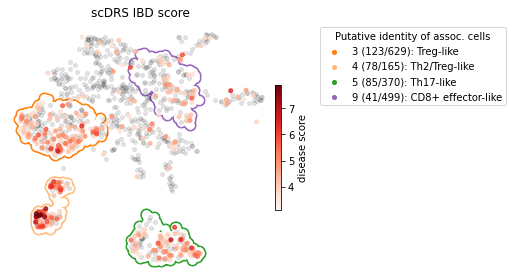

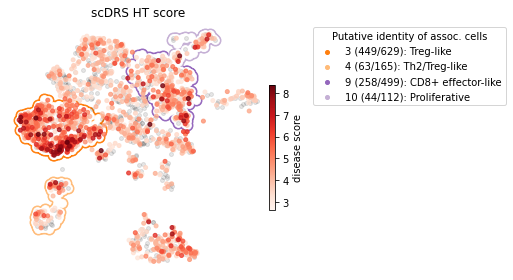

In [11]:
# UMAP plot with annotations
trait_list = ['PASS_IBD_deLange2017', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP']
dic_config = {}

dic_config['PASS_IBD_deLange2017'] = {
    '3.sig' : ['3 @a: Treg-like'], 
    '4.sig' : ['4 @a: Th2/Treg-like'],
    '5.sig' : ['5 @a: Th17-like'], 
    '9.sig' : ['9 @a: CD8+ effector-like']
}

dic_config['UKB_460K.disease_HYPOTHYROIDISM_SELF_REP'] = {
    '3.sig' : ['3 @a: Treg-like'], 
    '4.sig' : ['4 @a: Th2/Treg-like'],
    '9.sig' : ['9 @a: CD8+ effector-like'],
    '10.sig' : ['10 @a: Proliferative'],
}
cmap = matplotlib.cm.get_cmap('tab20')

for trait in trait_list:
    # Get df_plot 
    df_plot = pd.DataFrame(index=adata_assoc.obs_names, 
                           data={'UMAP1':adata_assoc.obsm['X_umap'][:,0],
                                 'UMAP2':adata_assoc.obsm['X_umap'][:,1]})
    df_plot = df_plot.join(adata_assoc.obs[
        ['leiden_reorder', 'cell', 
         '%s.fdr'%trait, '%s.norm_score'%trait, 'leiden_sig.%s'%trait, 'leiden_sig_full.%s'%trait]
    ])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    for x in dic_top_group[trait]:
        if x not in dic_config[trait]:
            dic_config[trait][x] = ['%s @a'%x.split('.')[0]]

    # Figure 
    plt.figure(figsize=[7.2,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')

    # Cluster boundry 
    x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
    y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
    for cluster in dic_top_group[trait]:
        ind_select = df_plot['leiden_reorder']==cluster.split('.')[0]
        assoc_str = '(%d/%d)'%((ind_select&(df_plot['leiden_sig.%s'%trait]!='nonsig')).sum(), ind_select.sum())
        temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
        xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
        xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
        ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
        ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
        ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                        (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                    s=16, color=cmap(int(cluster.split('.')[0])-1),
                    label=dic_config[trait][cluster][0].replace('@a',assoc_str), zorder=0)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=120, color=cmap(int(cluster.split('.')[0])-1), zorder=1)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=60, color='w', zorder=2)

    ind_select_sig = (df_plot['leiden_sig_full.%s'%trait]!='nonsig')
    np.random.seed(0)
    cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                        size=int((~ind_select_sig).sum()*0.2), replace=False)
    plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                    c='k', s=16, alpha=0.1, zorder=5)

    vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
                c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
                cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
    plt.colorbar(shrink=0.5, pad=0, label='disease score')
    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', title='Putative identity of assoc. cells')
    plt.title('scDRS %s score'%DF_TRAIT_INFO.loc[trait, 'Code'])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc_annot.%s.%s.svg'%(score, trait))
    plt.show()

### Annotating associated cells
- SEGs (per trait)
- Marker gene ranks (per trait)
- Marker gene dot plot (per trait)
- Marker gene expression UMAP (one figure for all traits)

|   IBD    |cluster 3 | 123/629 sig cells  |  506 nonsig cells  


cell
cell_ontology_class                  
CD4-positive, alpha-beta T cell  80.0
CD8-positive, alpha-beta T cell   6.0
T cell                           24.0
regulatory T cell                13.0

|   IBD    |cluster 4 |  78/165 sig cells  |  87 nonsig cells   


cell
cell_ontology_class                  
CD4-positive, alpha-beta T cell  28.0
T cell                           49.0

|   IBD    |cluster 5 |  85/370 sig cells  |  285 nonsig cells  


cell
cell_ontology_class      
T cell               78.0

|   IBD    |cluster 9 |  41/499 sig cells  |  458 nonsig cells  


cell
cell_ontology_class                  
CD8-positive, alpha-beta T cell  24.0
T cell                           13.0

|    HT    |cluster 3 | 449/629 sig cells  |  180 nonsig cells  


cell
cell_ontology_class                  
CD4-positive, alpha-beta T cell   345
CD8-positive, alpha-beta T cell    15
T cell                             59
regulatory T cell                  28

|    HT    |cluster 4 |  63/165 sig cells  |  102 nonsig cells  


cell
cell_ontology_class                  
CD4-positive, alpha-beta T cell  27.0
T cell                           34.0

|    HT    |cluster 9 | 258/499 sig cells  |  241 nonsig cells  


cell
cell_ontology_class                   
CD4-positive, alpha-beta T cell   17.0
CD8-positive, alpha-beta T cell  158.0
T cell                            83.0

|    HT    |cluster 10|  44/112 sig cells  |  68 nonsig cells   


cell
cell_ontology_class                  
CD4-positive, alpha-beta T cell   6.0
CD8-positive, alpha-beta T cell  12.0
T cell                           16.0
mature alpha-beta T cell          8.0

PASS_IBD_deLange2017


... storing 'tissue_celltype' as categorical
... storing 'leiden_reorder' as categorical
... storing 'phase' as categorical
... storing 'leiden_sig_full.PASS_IBD_deLange2017' as categorical
... storing 'leiden_sig.PASS_IBD_deLange2017' as categorical
... storing 'leiden_sig_full.PASS_CD_deLange2017' as categorical
... storing 'leiden_sig.PASS_CD_deLange2017' as categorical
... storing 'leiden_sig_full.PASS_UC_deLange2017' as categorical
... storing 'leiden_sig.PASS_UC_deLange2017' as categorical
... storing 'leiden_sig_full.PASS_Rheumatoid_Arthritis' as categorical
... storing 'leiden_sig.PASS_Rheumatoid_Arthritis' as categorical
... storing 'leiden_sig_full.PASS_Multiple_sclerosis' as categorical
... storing 'leiden_sig.PASS_Multiple_sclerosis' as categorical
... storing 'leiden_sig_full.UKB_460K.disease_AID_ALL' as categorical
... storing 'leiden_sig.UKB_460K.disease_AID_ALL' as categorical
... storing 'leiden_sig_full.UKB_460K.disease_HYPOTHYROIDISM_SELF_REP' as categorical
... stor

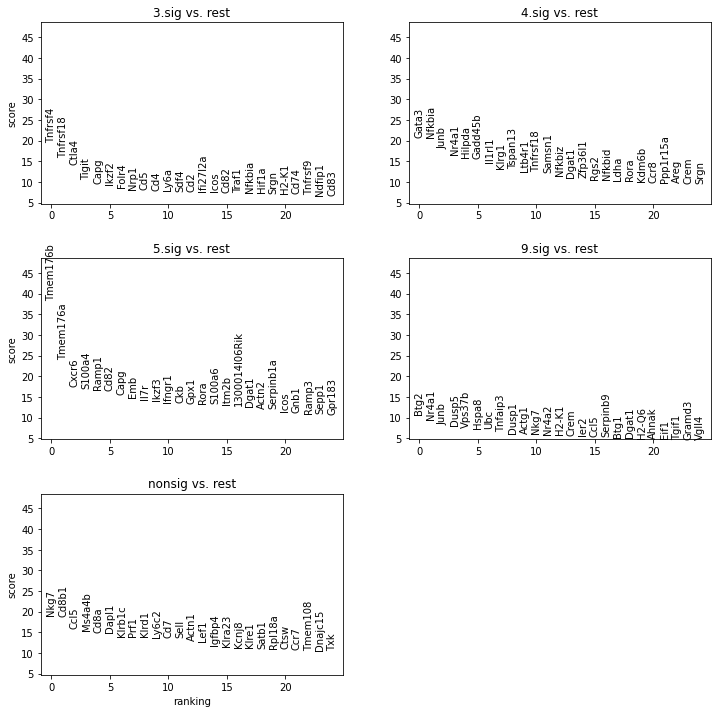

UKB_460K.disease_HYPOTHYROIDISM_SELF_REP


... storing 'tissue_celltype' as categorical
... storing 'leiden_reorder' as categorical
... storing 'phase' as categorical
... storing 'leiden_sig_full.PASS_IBD_deLange2017' as categorical
... storing 'leiden_sig.PASS_IBD_deLange2017' as categorical
... storing 'leiden_sig_full.PASS_CD_deLange2017' as categorical
... storing 'leiden_sig.PASS_CD_deLange2017' as categorical
... storing 'leiden_sig_full.PASS_UC_deLange2017' as categorical
... storing 'leiden_sig.PASS_UC_deLange2017' as categorical
... storing 'leiden_sig_full.PASS_Rheumatoid_Arthritis' as categorical
... storing 'leiden_sig.PASS_Rheumatoid_Arthritis' as categorical
... storing 'leiden_sig_full.PASS_Multiple_sclerosis' as categorical
... storing 'leiden_sig.PASS_Multiple_sclerosis' as categorical
... storing 'leiden_sig_full.UKB_460K.disease_AID_ALL' as categorical
... storing 'leiden_sig.UKB_460K.disease_AID_ALL' as categorical
... storing 'leiden_sig_full.UKB_460K.disease_HYPOTHYROIDISM_SELF_REP' as categorical
... stor

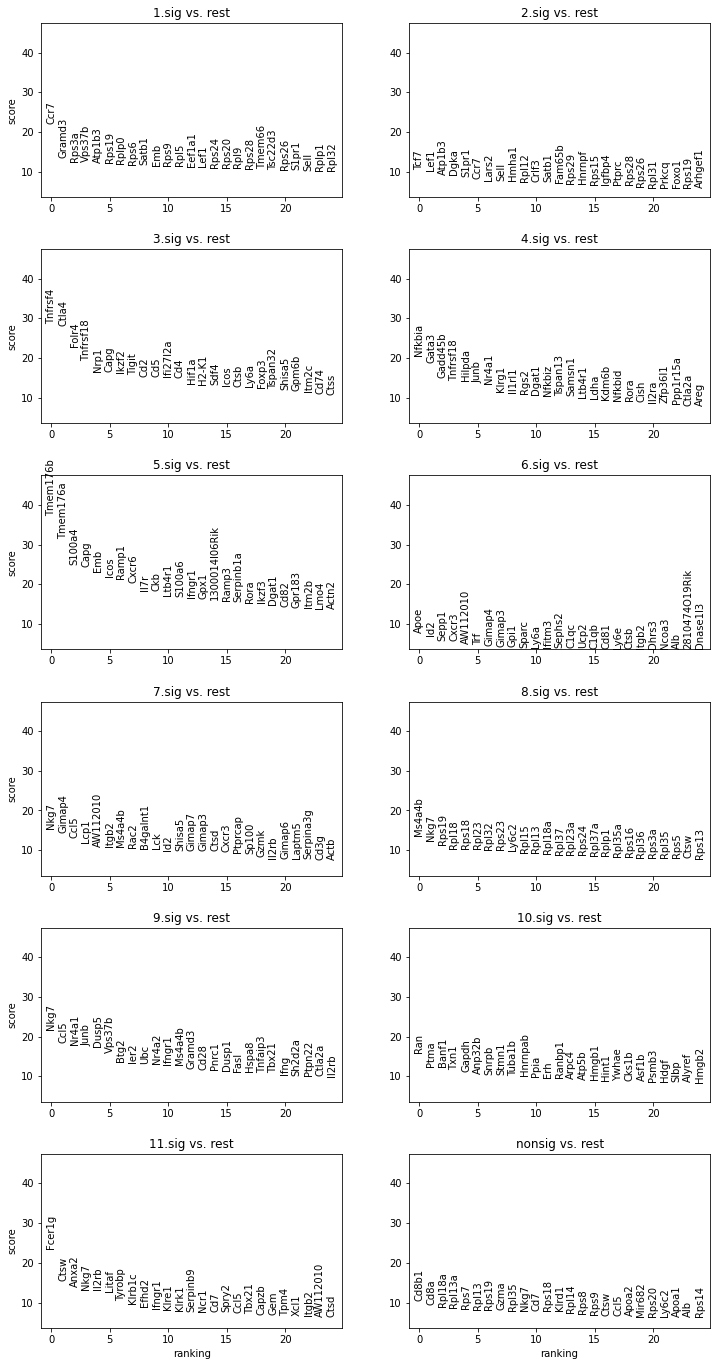

In [12]:
# Summarize significant cells in each top cluster
dic_data_annot = {}

for trait in trait_list:
    
    dic_data_annot[trait] = adata_assoc.copy()
    for group in dic_top_group[trait]:
        print('|{:^10s}|{:^10s}|{:^20s}|{:^20s}'.format(
            DF_TRAIT_INFO.loc[trait, 'Code'], 'cluster %s'%group.split('.')[0], 
            '%d/%d sig cells'%((dic_data_annot[trait].obs['leiden_sig.%s'%trait]==group).sum(),
                               (dic_data_annot[trait].obs['leiden_reorder']==group.split('.')[0]).sum()), 
            '%d nonsig cells'%((dic_data_annot[trait].obs['leiden_reorder']==group.split('.')[0]).sum() -
                               (dic_data_annot[trait].obs['leiden_sig.%s'%trait]==group).sum())
        ))
        temp_df = dic_data_annot[trait].obs.loc[dic_data_annot[trait].obs['leiden_sig.%s'%trait]==group].copy()
        temp_df = temp_df.groupby('cell_ontology_class').agg({'cell':len})
        temp_df = temp_df.loc[temp_df['cell']>=5]
        display(temp_df)
        
# Specifically expressed genes 
for trait in trait_list:
    print(trait)
    sc.tl.rank_genes_groups(dic_data_annot[trait], groupby='leiden_sig.%s'%trait)
    sc.pl.rank_genes_groups(dic_data_annot[trait], fontsize=10, ncols=2, n_genes=25)

In [13]:
# Define marker genes
# https://www.rndsystems.com/resources/cell-markers/immune-cells/helper-t-cells
DIC_MARKER = {}
DIC_MARKER['Basic'] = [
    'Cd3d', 'Cd4', 'Cd8a'
]
DIC_MARKER['Naive'] = [
    'Ccr7', 'Sell', 'Il7r', 'Il2rg', 'Lef1', 'Klf2', 
    # Ccr7, Sell, Lef1, Klf2 : Naive T
    # Sell (CD62L)
    # Il7r (CD127)
    # Il2rg (CD132)
    # Lef1, Klf2 : Chen_MolOnco_2021
    # They express surface markers, such as CD45RA, CCR7, CD62L, CD127, and CD132. They lack expression
    # of markers of previous activation, such as CD25, CD44, CD69, CD45RO, or HLA-DR.
] 

DIC_MARKER['Treg'] = [
    'Cd4', 'Il2ra', 'Foxp3', 'Entpd1', 'Nt5e', 'Ctla4', 'Tnfrsf18', 'Lag3', 
    'Lrrc32', 'Nrp1', 'Tgfb1', 'Il10', 'Il12a',
    # Il2ra (CD25)
    # Foxp3 : master regulator of regulatory pathway in development and function of Treg
    # Entpd1 (CD39)    
    # Nt5e (5’ Nucleotidase/CD73)
    # Ctla4 : immune checkpoint and downregulates immune responses (T cell proliferation), 
    # Tnfrsf18 (Gitr) : co-stimulatory immune checkpoint molecule, play a key role in dominant 
    # immunological self-tolerance maintained by CD25+/CD4+ regulatory T cells  
    # Lag3 : Treg suppressive function
    # Nrp1 (Neuropilin-1) : angiogenesis, axon guidance, cell survival, migration, and invasion, 
    # Tgfb1 (TGF-beta)
    # Il12a (Il35)
    # Tregs are most commonly identified as CD3+CD4+CD25+FoxP3+ cells in both mice and humans. 
    # Additional cell surface markers include CD39, 5’ Nucleotidase/CD73, CTLA-4, GITR, LAG-3, 
    # LRRC32, and Neuropilin-1. Tregs can also be identified based on the secretion of immunosuppressive 
    # cytokines including TGF-beta, IL-10, and IL-35.
    'Folr4', 'Tnfrsf4', 
    # Folr4 (Folate Receptor 4) : cell-surface marker of Tregs
    # Tnfrsf4 (OX40/CD134) : secondary co-stimulatory immune checkpoint molecule
    # "A non‐redundant role for OX40 in the competitive fitness of Treg in response to IL‐2"
    # Piconese EJI 2010    
]
DIC_MARKER['KA-Treg'] = [
    'Il1rl1', 'Klrg1', 'Areg', 'Gata3', # KA Treg
    # Il1rl1 (St2) : enhance Treg functions 
    # Klrg1 : co-inhibitory immune checkpoint, Treg differentiation
    # Areg : tissue repair. endogenous AREG with IL-33 decreased the intestinal inflammation in 
      # mice with normal count of T-lymphocytes and in deficient mice
    # Gata3 : promote St2 by binding to an enhancer element Foxp3
]
DIC_MARKER['Tfh'] = [
    'Cd4', 'Cxcr5', 'Icos', 'Pdcd1', 'Cxcl13', 'Il4', 'Il21', 'Il6ra', 'Stat3', 'Bcl6',
    # Pdcd1 (PD1)
    # Il6ra (IL-6 R alpha)
    # Both human and mice Tfh cells are most commonly identified as cells that express 
    # the cell surface markers CD4, CXCR5, ICOS, and PD-1, and secrete CXCL13, IL-4, and IL-21. 
    # Additionally, Tfh cells express high levels of IL-6 R alpha, and the transcription factors, 
    # STAT3 and Bcl-6
]
DIC_MARKER['Th1'] = [
    'Cd4', 'Il12rb2', 'Il27ra', 'Ifngr2', 'Il18r1', 'Ccr5', 'Cxcr3', 'Stat4', 'Tbx21',
    # Il12rb2 (IL-12 R beta 2)
    # Ifngr2 (IFN-gamma R2)
    # Il18r1 (IL-18 R)
    # Tbx21 (T-bet)
    # They can be distinguished from other CD3+CD4+CD8- T cells based on the cell surface expression
    # of IL-12 R beta 2, IL-27 R alpha/WSX-1, IFN-gamma R2, IL-18 R, CCR5, and CXCR3, and the expression
    # of the transcriptional regulators, STAT4 and T-bet
]
DIC_MARKER['Th2'] = [
    'Cd4', 'Ccr3', 'Ccr4', 'Ccr8', 'Cxcr4', 'Il1rl1', 'Stat5a', 'Stat6',
    'Gata3', 'Il4', 'Il5', 'Il9', 'Il13', 'Il25',
    # Il1rl1 (ST2)
    # Stat5s (STAT5)
    # Il25 (IL-17E/IL-25)
    # commonly distinguished from other CD3+CD4+CD8- T helper cell subsets based on expression of 
    # the cell surface markers CCR3, CCR4, CCR8, CXCR4, and ST2/IL-1 R4, along with the transcriptional
    # regulators, STAT5, STAT6, and GATA-3, the last of which is the master transcriptional regulator 
    # required for Th2 cell development. In addition to these markers, the cytokines commonly secreted 
    # by Th2 cells, including IL-4, IL-5, IL-9, IL-13, and IL-17E/IL-25 can also be used to distinguish
    # Th2 cells from other CD4+ effector T cell subsets.
]
DIC_MARKER['Th9'] = [
    'Cd4', 'Sfpi1', 'Irf4', 'Il9', 'Ccl17', 'Ccl22', 'Il10',
    # Sfpi1 (PU.1/Spi-1)
    # They develop from naïve CD4+ T cells in the presence of TGF-beta and IL-4, which induce the 
    # expression of the transcription factors, PU.1/Spi-1 and IRF4, respectively. IL-9 is the principal 
    # cytokine secreted by Th9 cells following activation. In addition, Th9 cells also secrete CCL17, 
    # CCL22, and IL-10 (in mouse). Notably, they do not express cytokines characteristic of other T helper
    # cell subsets including the Th2-related cytokines, IL-4, IL-5, and IL-13, the Th17-related cytokine, 
    # IL-17A, or the Th1-related cytokine, IFN-gamma. They also do not express the primary transcription 
    # factors that regulate the differentiation of other T helper cell subsets including T-bet (Th1 cells), 
    # GATA-3 (Th2 cells), ROR gamma t (Th17 cells), or FoxP3 (regulatory T cells).
]
DIC_MARKER['Th17'] = [
    'Cd4', 'Tgfbr1', 'Il6ra', 'Il21r', 'Il23r', 'Stat3', 'Rorc', 'Il17a', 'Il17f', 'Il21', 'Il22',
    # Tgfbr1 (TGF-beta R)
    # Rorc (ROR-gamma t) : differentiation of Th17 cells
    # Il23r : enhances Th17 differentiation
    # # Il17a/Il17f : inducing and mediating proinflammatory responses
    # express TGF-beta R, IL-6 R alpha, IL-21 R, IL-23R, and the transcription factors, STAT3 and 
    # ROR-gamma t, the latter of which is the master transcriptional regulator required for Th17 
    # cell development. In addition to these cell surface and intracellular markers, mouse and human 
    # Th17 cells can be distinguished from other CD4+ T cell subsets based on the production of IL-17A,
    # IL-17F, IL-21, and IL-22.
    'Il1r1', 
    # Il1r1 (IL-1 RI) : Th17 differentiation
]
DIC_MARKER['Th22'] = [
    'Cd4', 'Il22', 'Ccr4', 'Ccr6', 'Ccr10', 'Fgf1', 'Fgf2', 'Fgf4', 'Il13', 'Tnf', 'Ahr',
    # Fgf1, Fgf2, Fgf4 (fibroblast growth factors (FGFs))
    # Tnf (TNF-alpha)
    # Ahr (aryl hydrocarbon receptor (AHR) transcription factor)
    # They produce high levels of IL-22, but not IL-17, IFN-gamma, or IL-4. In addition to IL-22, these 
    # cells express CCR4, CCR6, CCR10, several fibroblast growth factors (FGFs), IL-13, TNF-alpha, and 
    # the aryl hydrocarbon receptor (AHR) transcription factor. Although Th22 cells share many similarities 
    # with Th17 cells including expression of CCR4, CCR6, and IL-22, Th22 cells are distinguished from Th17 
    # cells in that they express CCR10 and lack expression of both CD161 and IL-17.
]
# DIC_MARKER['Th22_neg'] = [
#     'Klrb1a', 'Klrb1b', 'Klrb1c', 'Klrb1f', 'Il17a', 'Il17f', 
#     # Th22 cells are distinguished from Th17 
#     # cells in that they express CCR10 and lack expression of both CD161 and IL-17.
# ]
DIC_MARKER['Eff_CD8'] = [
    'Cd8a', 'Ifng', 'Prf1', 'Nkg7', 'Gzma', 'Gzmb', 'Gzmk', 'Gzmm', 'Fasl',
    # Igng : also produced by Cd8 T cells
    # Prf1 : forms a pore in the membrane of the target cell
    # Nkg7 : NK and CD8+ T cell cytotoxic degranulation
    # Gzma,Gzmb,Gzmh,Gzmk : serine proteases which cleave the proteins inside the cell, 
    # resulting in apoptosis of target cell.
    # Fasl : Fas ligandl Its binding with its receptor induces apoptosis
]
DIC_MARKER['Prolif'] = [
    'Mcm5', 'Mki67', 'Stmn1', 'Cdk1', 'Ccna2'
    # Mki67 (Ki67) : recent cell division
    # Mcm5, Stmn1, Cdk1, Ccna2 : proliferation-associated genes
]

for term in DIC_MARKER:
    for gene in DIC_MARKER[term].copy():
        if gene not in adata_assoc.var_names:
            print('Missing {:^15s} {:^15s}'.format(term, gene))
            DIC_MARKER[term].remove(gene)
    print('Summary {:^15s} {:^80s}'.format(term, ','.join(DIC_MARKER[term]))) 

Summary      Basic                                       Cd3d,Cd4,Cd8a                                  
Summary      Naive                               Ccr7,Sell,Il7r,Il2rg,Lef1,Klf2                         
Summary      Treg       Cd4,Il2ra,Foxp3,Entpd1,Nt5e,Ctla4,Tnfrsf18,Lag3,Lrrc32,Nrp1,Tgfb1,Il10,Il12a,Folr4,Tnfrsf4
Summary     KA-Treg                                 Il1rl1,Klrg1,Areg,Gata3                             
Summary       Tfh                    Cd4,Cxcr5,Icos,Pdcd1,Cxcl13,Il4,Il21,Il6ra,Stat3,Bcl6              
Summary       Th1                   Cd4,Il12rb2,Il27ra,Ifngr2,Il18r1,Ccr5,Cxcr3,Stat4,Tbx21             
Summary       Th2           Cd4,Ccr3,Ccr4,Ccr8,Cxcr4,Il1rl1,Stat5a,Stat6,Gata3,Il4,Il5,Il9,Il13,Il25    
Summary       Th9                             Cd4,Sfpi1,Irf4,Il9,Ccl17,Ccl22,Il10                       
Summary      Th17             Cd4,Tgfbr1,Il6ra,Il21r,Il23r,Stat3,Rorc,Il17a,Il17f,Il21,Il22,Il1r1       
Summary      Th22                     Cd4,Il2

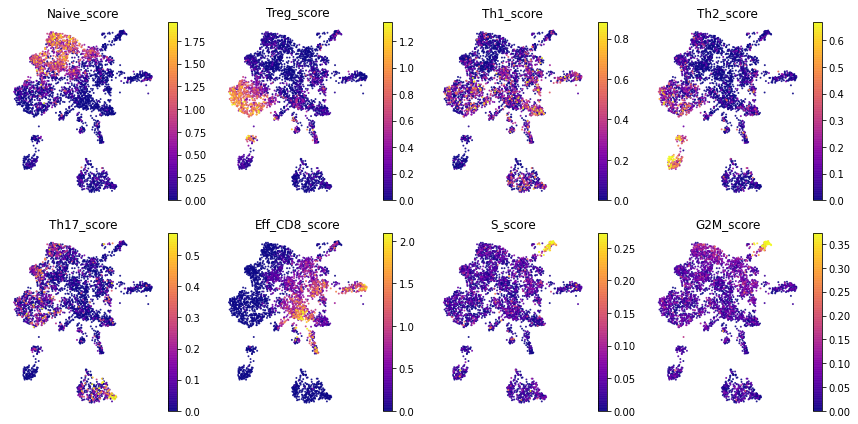

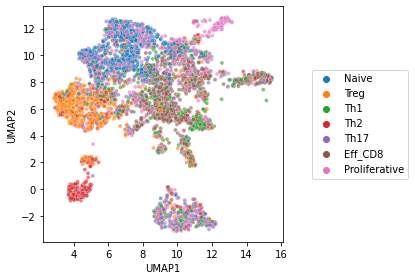

In [14]:
# Score cells using subtype signatures 
temp_adata = adata_assoc.copy()
for term in DIC_MARKER:
    sc.tl.score_genes(temp_adata, DIC_MARKER[term], score_name='%s_score'%term)

df_subtype = pd.DataFrame(
    index=adata_assoc.obs_names, data={
        'UMAP1' : adata_assoc.obsm['X_umap'][:,0], 'UMAP2' : adata_assoc.obsm['X_umap'][:,1],
        'S_score' : adata_assoc.obs['S_score'], 'G2M_score' : adata_assoc.obs['G2M_score'],
    })
subtype_score_list = ['Naive_score', 'Treg_score', 'Th1_score', 'Th2_score', 'Th17_score', 'Eff_CD8_score']
df_subtype = df_subtype.join(temp_adata.obs[subtype_score_list])
subtype_score_list += ['S_score', 'G2M_score']

# A simple classification
temp_mat = df_subtype[subtype_score_list].values.copy()
temp_mat = (temp_mat - np.median(temp_mat, axis=0)) / temp_mat.std(axis=0)
temp_list = np.array([x.replace('_score','') for x in subtype_score_list])
df_subtype['subtype'] = temp_list[np.argmax(temp_mat, axis=1)]
df_subtype.loc[df_subtype['subtype'].isin(['S', 'G2M']), 'subtype'] = 'Proliferative'
subtype_list = ['Naive', 'Treg', 'Th1', 'Th2', 'Th17', 'Eff_CD8', 'Proliferative']

# UMAP for score
df_plot = df_subtype.copy()
plt.figure(figsize=[12,6])
for i,subtype in enumerate(subtype_score_list):
    ax = plt.subplot(2,4,i+1)
    ax.axis('off')
    vmax = np.quantile(df_plot[subtype], 0.99) * 1.2
    df_plot.sort_values(subtype, ascending=True, inplace=True)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[subtype],
                cmap='plasma', s=1, vmax=vmax, vmin=0, alpha=0.8)
    plt.colorbar()
    plt.title(subtype)
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.subtype_score_umap.png')
plt.show()

# UMAP for classification
plt.figure(figsize=[6,4])
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='subtype', 
                    s=16, alpha=0.6, hue_order=subtype_list)
g.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.subtype_umap.png')
plt.show()

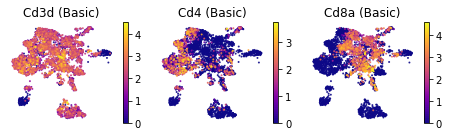

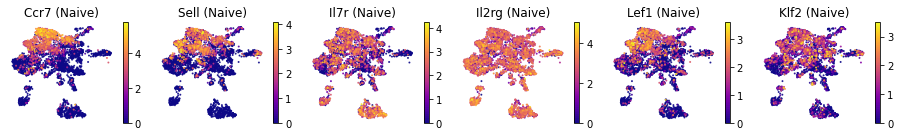

Treg Lrrc32 0.018074669
Treg Tgfb1 0.03445566
Treg Il10 0.040141508


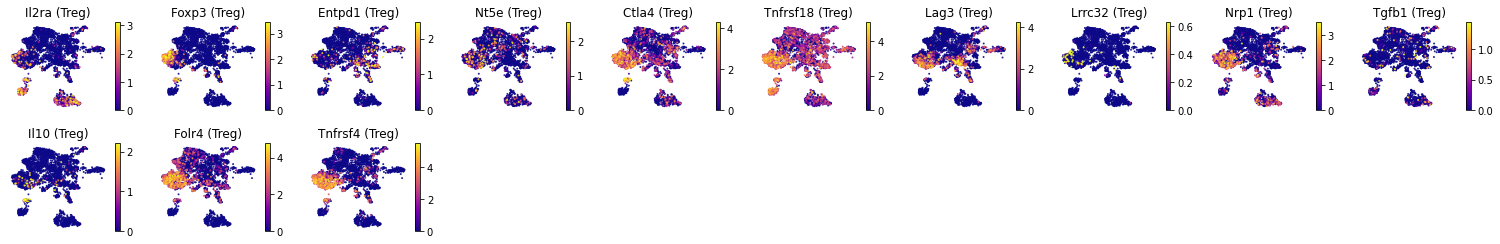

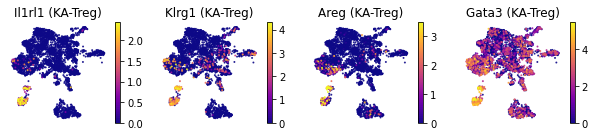

Tfh Il4 0.016755763
Tfh Il21 0.011130841
Tfh Bcl6 0.021801915


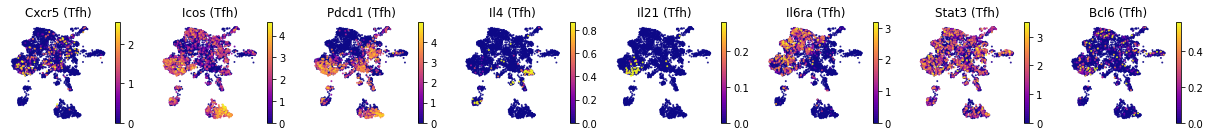

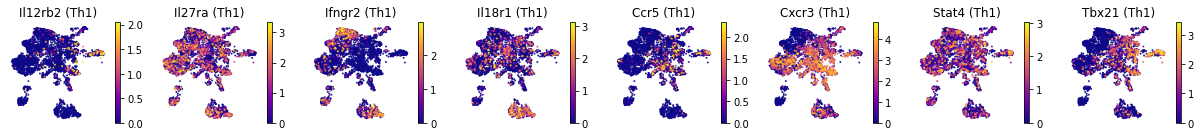

Th2 Ccr4 0.04646601
Th2 Cxcr4 0.03533393
Th2 Il4 0.016755763
Th2 Il5 0.026230915


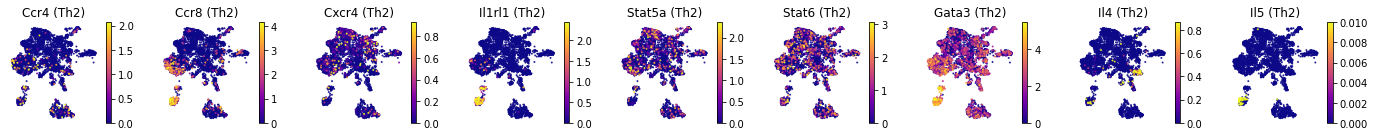

Th9 Sfpi1 0.019531883
Th9 Irf4 0.03062233
Th9 Il10 0.040141508


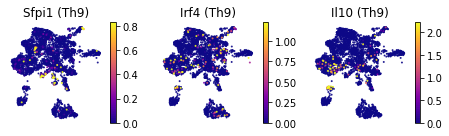

Th17 Tgfbr1 0.043263275
Th17 Il17f 0.024981022
Th17 Il21 0.011130841


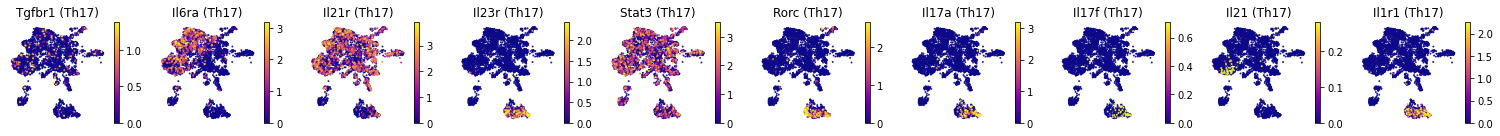

Th22 Ccr4 0.04646601
Th22 Ahr 0.036842212


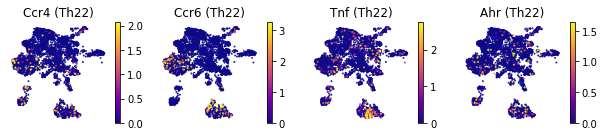

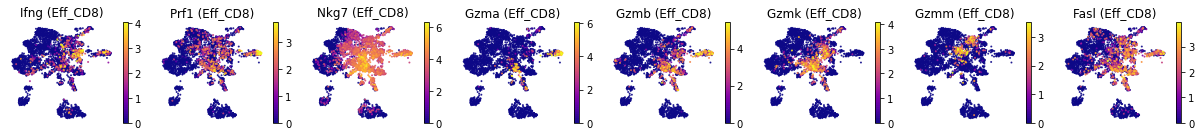

Prolif Cdk1 0.04589018
Prolif Ccna2 0.033883803


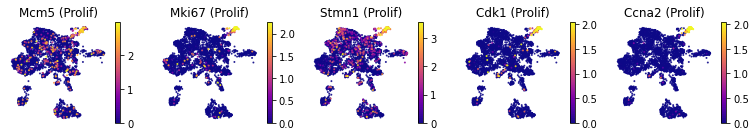

In [15]:
# UMAP for marker genes, by subtype
for term in DIC_MARKER:
    df_plot = pd.DataFrame(
        index=adata_assoc.obs_names, data={
            'UMAP1' : adata_assoc.obsm['X_umap'][:,0], 'UMAP2' : adata_assoc.obsm['X_umap'][:,1],
        })
    gene_plot_list = []
    for gene in DIC_MARKER[term]:
        if (term != 'Basic') & (gene in ['Cd4', 'Cd8a']):
            continue
        if adata_assoc[:, gene].X.mean()>0.01:
            if adata_assoc[:, gene].X.mean()<0.05:
                print(term, gene, adata_assoc[:, gene].X.mean())
            df_plot[gene] = adata_assoc[:, gene].X.toarray().flatten()
            gene_plot_list.append(gene)
    nrow = np.ceil(len(gene_plot_list) / 10).astype(int)
    ncol = 10 if nrow<=10 else nrow

    plt.figure(figsize=[1+2*ncol, 0.5+1.5*nrow])
    for i,gene in enumerate(gene_plot_list):
        ax = plt.subplot(nrow,ncol,i+1)
        ax.axis('off')
        vmax = np.max([np.quantile(df_plot[gene], 0.99) * 1.2, 0.01])
        df_plot.sort_values(gene, ascending=True, inplace=True)
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene],
                    cmap='plasma', s=1, vmax=vmax, vmin=0, alpha=0.8)
        plt.colorbar()
        plt.title('%s (%s)'%(gene, term))

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc.marker_gene_umap.%s.png'%term)
    plt.show()

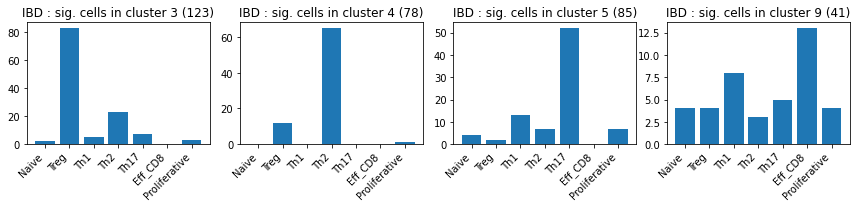

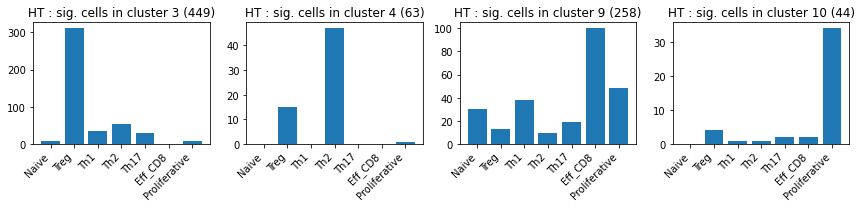

In [16]:
# Per trait info: barplot for predicted subtype
for trait in trait_list:
    plt.figure(figsize=[12,3])
    for i,group in enumerate(dic_top_group[trait]):
        
        # Get df_subtype results 
        ind_select = dic_data_annot[trait].obs['leiden_sig.%s'%trait] == group
        n_cell_group = ind_select.sum()
        temp_df = dic_data_annot[trait][ind_select, :].obs.copy()
        temp_df = temp_df.join(df_subtype[['subtype']])
        
        temp_df = temp_df.groupby('subtype').agg({'cell':len})
        for ct in subtype_list:
            if ct not in temp_df.index:
                temp_df.loc[ct] = [0]
        
        # Barplot
        plt.subplot(1,4,i+1)
        plt.bar(np.arange(len(subtype_list)), temp_df.loc[subtype_list, 'cell'])
        plt.xticks(np.arange(len(subtype_list)), subtype_list, ha='right', rotation=45)
        plt.title('%s : sig. cells in cluster %s (%d)'
                  %(DF_TRAIT_INFO.loc[trait, 'Code'], group.split('.')[0], n_cell_group))
    
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc.subtype_comp.%s.svg'%(trait))
    plt.show()

n_marker=47
| IBD |  Prolif  |        Cd3d        |  3.sig:477      4.sig:22820    5.sig:19323    9.sig:8924   |
| IBD |  Prolif  |        Cd4         |  3.sig:9        4.sig:16118    5.sig:21067    9.sig:4214   |
| IBD |  Prolif  |        Cd8a        |  3.sig:22964    4.sig:22963    5.sig:22964    9.sig:188    |
| IBD |  Prolif  |    Il2ra (Treg)    |  3.sig:166      4.sig:26       5.sig:97       9.sig:21339  |
| IBD |  Prolif  |    Foxp3 (Treg)    |  3.sig:39       4.sig:228      5.sig:22910    9.sig:22932  |
| IBD |  Prolif  |    Nt5e (Treg)     |  3.sig:342      4.sig:21436    5.sig:8841     9.sig:5123   |
| IBD |  Prolif  |    Ctla4 (Treg)    |  3.sig:2        4.sig:405      5.sig:14738    9.sig:1445   |
| IBD |  Prolif  |  Tnfrsf18 (Treg)   |  3.sig:1        4.sig:10       5.sig:20381    9.sig:363    |
| IBD |  Prolif  |    Lag3 (Treg)     |  3.sig:53       4.sig:21229    5.sig:22839    9.sig:8023   |
| IBD |  Prolif  |    Nrp1 (Treg)     |  3.sig:7        4.sig:13137    5.sig:43

... storing 'leiden_sig_anno' as categorical


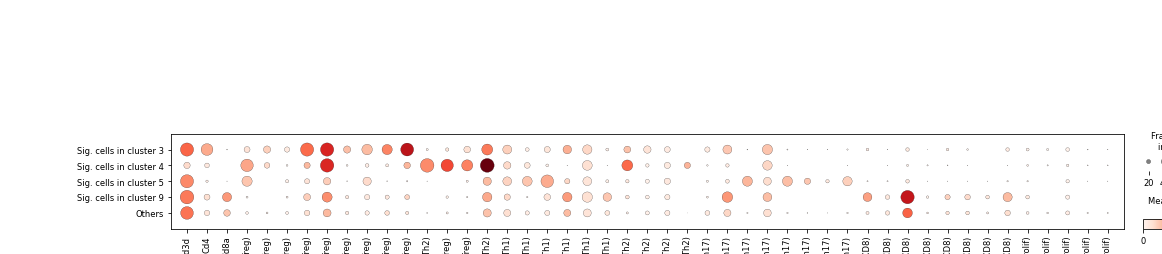

| HT  |  Prolif  |        Cd3d        | 3.sig:245      4.sig:22520    9.sig:2448     10.sig:12069  |
| HT  |  Prolif  |        Cd4         | 3.sig:11       4.sig:8079     9.sig:21885    10.sig:3175   |
| HT  |  Prolif  |        Cd8a        | 3.sig:22965    4.sig:22965    9.sig:48       10.sig:14454  |
| HT  |  Prolif  |    Il2ra (Treg)    | 3.sig:356      4.sig:20       9.sig:22957    10.sig:5277   |
| HT  |  Prolif  |    Foxp3 (Treg)    | 3.sig:18       4.sig:118      9.sig:22935    10.sig:11994  |
| HT  |  Prolif  |    Nt5e (Treg)     | 3.sig:110      4.sig:9322     9.sig:11524    10.sig:22676  |
| HT  |  Prolif  |    Ctla4 (Treg)    | 3.sig:1        4.sig:168      9.sig:1181     10.sig:2067   |
| HT  |  Prolif  |  Tnfrsf18 (Treg)   | 3.sig:3        4.sig:3        9.sig:4988     10.sig:1033   |
| HT  |  Prolif  |    Lag3 (Treg)     | 3.sig:33       4.sig:19792    9.sig:9899     10.sig:6345   |
| HT  |  Prolif  |    Nrp1 (Treg)     | 3.sig:4        4.sig:12239    9.sig:19710    10.sig

... storing 'leiden_sig_anno' as categorical


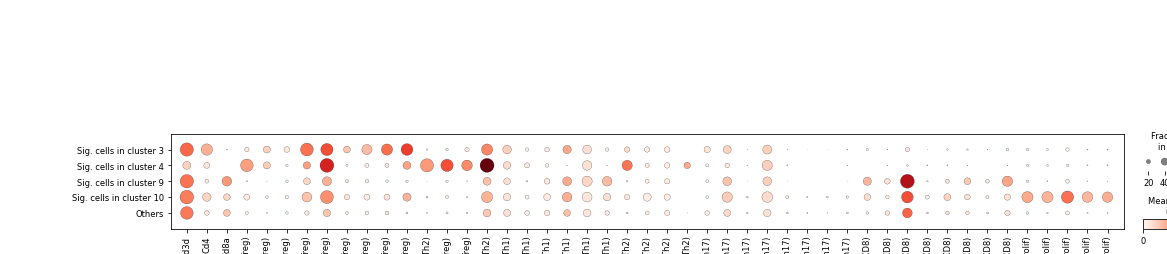

In [17]:
# Marker list to show
marker_list = []
white_set = {'Il1rl1', 'Il5', 'Il23r', 'Rorc', 'Il17a', 'Il17f', 'Il1r1', 'Mki67', 'Cdk1', 'Ccna2'}
dic_name = {}
for term in ['Basic', 'Treg', 'KA-Treg', 'Th1', 'Th2', 'Th17', 'Eff_CD8', 'Prolif']:
    for gene in DIC_MARKER[term]:
        if (adata_assoc[:, gene].X.mean()<0.1) & (gene not in white_set):
            continue
        if gene not in marker_list:
            marker_list.append(gene)
            dic_name[gene] = term
        else: 
            dic_name[gene] += ';%s'%term
for gene in dic_name:
    if gene in DIC_MARKER['Basic']:
        dic_name[gene] = gene
    else:
        dic_name[gene] = '%s (%s)'%(gene, dic_name[gene])
print('n_marker=%d'%len(marker_list))

for trait in trait_list:
    adata = dic_data_annot[trait]
    # Marker gene info
    for gene in marker_list:
        print('|{:^5s}|{:^10s}|{:^20s}|{:^60s}|'.format(
            DF_TRAIT_INFO.loc[trait, 'Code'], term, dic_name[gene],
            '    '.join(['%s:%-5d'%(x, np.where(adata.uns['rank_genes_groups']['names'][x]==gene)[0][0]) 
                         for x in dic_top_group[trait]])))
            
    # Dotplot for marker genes in each cluster
    adata = dic_data_annot[trait].copy()
    adata.var_names = [dic_name[x] if x in dic_name else x for x in adata.var_names]
    temp_set = set(dic_top_group[trait])
    adata.obs['leiden_sig_anno'] = [
        'Sig. cells in cluster %s'%x.split('.')[0] if x in temp_set else 'Others' 
        for x in adata.obs['leiden_sig.%s'%trait]]    
    sc.pl.dotplot(
        adata, [dic_name[x] for x in marker_list], groupby='leiden_sig_anno', 
        categories_order=['Sig. cells in cluster %s'%x.split('.')[0] for x in dic_top_group[trait]] + ['Others'], 
        save='sctrs_assoc.annot_%s_umap_marker_gene.svg'%DF_TRAIT_INFO.loc[trait, 'Code'])

### Annotating associated cells : ProjecTILs

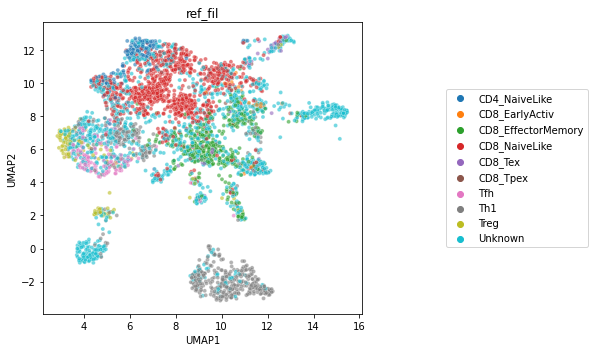

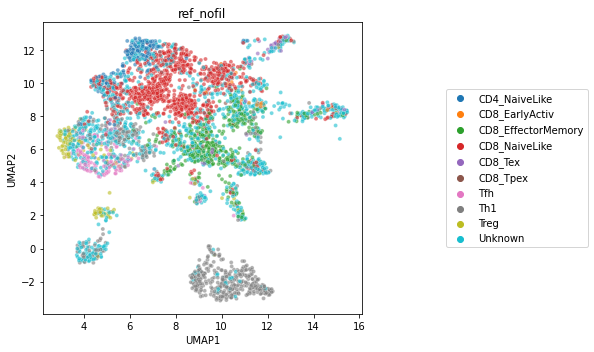

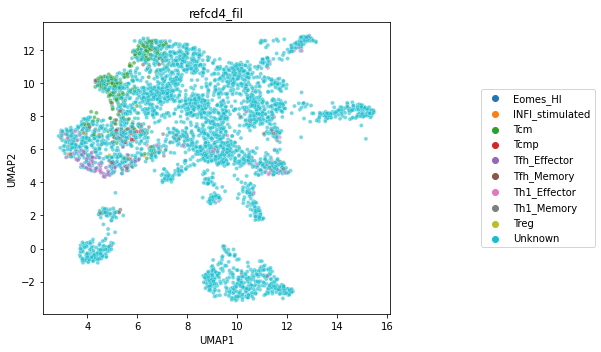

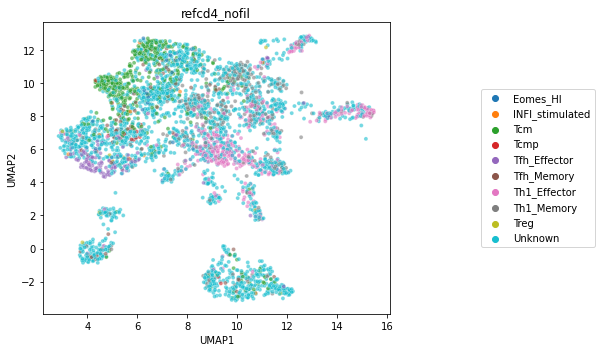

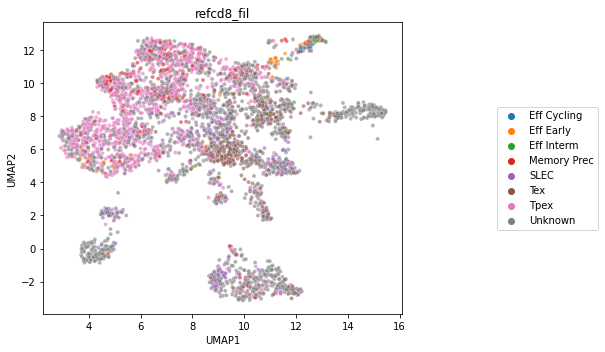

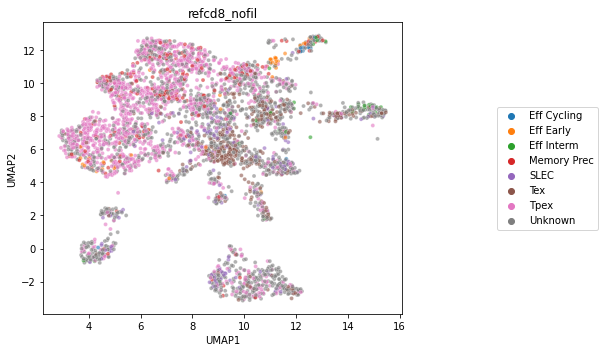

In [18]:
dic_ProjecTILs_res_path = {
    'ref_fil' : DATA_PATH + '/reference.ProjecTILs/res.ProjecTILs.ref.FilCell.tsv',
    'ref_nofil' : DATA_PATH + '/reference.ProjecTILs/res.ProjecTILs.ref.NoFilCell.tsv',
    'refcd4_fil' : DATA_PATH + '/reference.ProjecTILs/res.ProjecTILs.ref_cd4.FilCell.tsv',
    'refcd4_nofil' : DATA_PATH + '/reference.ProjecTILs/res.ProjecTILs.ref_cd4.NoFilCell.tsv',
    'refcd8_fil' : DATA_PATH + '/reference.ProjecTILs/res.ProjecTILs.ref_cd8.FilCell.tsv',
    'refcd8_nofil' : DATA_PATH + '/reference.ProjecTILs/res.ProjecTILs.ref_cd8.NoFilCell.tsv',
}

dic_ProjecTILs_res = {}
for res in dic_ProjecTILs_res_path:
    dic_ProjecTILs_res[res] = pd.read_csv(dic_ProjecTILs_res_path[res], sep='\t')
    
REFCT_LIST = ['CD4_NaiveLike', 'Tfh', 'Th1', 'Treg', 
              'CD8_NaiveLike', 'CD8_EarlyActiv', 'CD8_EffectorMemory', 'CD8_Tpex', 'CD8_Tex', 'Unknown']

# Visualize results 
for res in dic_ProjecTILs_res:
    df_plot = pd.DataFrame(index=adata_assoc.obs_names, 
                           data={'UMAP1' : adata_assoc.obsm['X_umap'][:,0],
                                 'UMAP2' : adata_assoc.obsm['X_umap'][:,1],
                                })
    df_plot = df_plot.join(dic_ProjecTILs_res[res])
    ind_select = df_plot['functional.cluster'].isna()
    ind_select = df_plot['functional.cluster'].isna() | (df_plot['functional.cluster.conf']<0.8)
    df_plot.loc[ind_select, 'functional.cluster'] = 'Unknown'
    
    plt.figure(figsize=[9,5])
    g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='functional.cluster', 
                        s=16, alpha=0.6, hue_order=sorted(df_plot['functional.cluster'].unique()))
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.title(res)
    plt.tight_layout()
    plt.show()

PASS_IBD_deLange2017


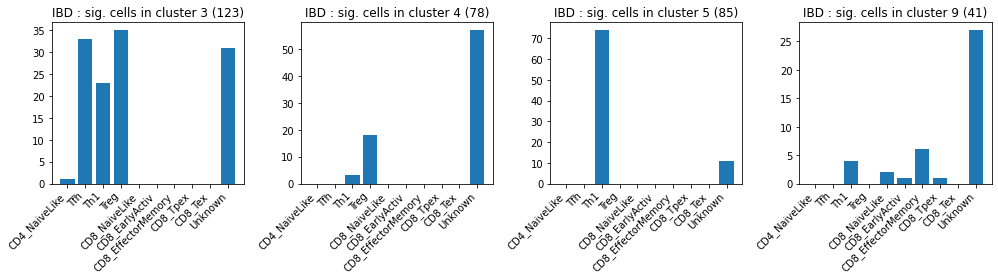

UKB_460K.disease_HYPOTHYROIDISM_SELF_REP


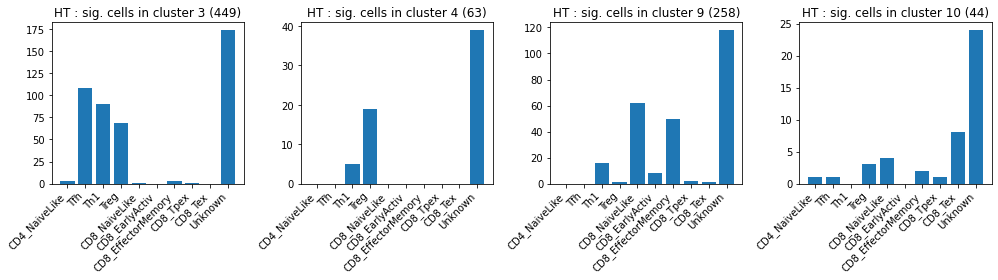

In [19]:
ref = 'ref_fil'
ct_list = REFCT_LIST
for trait in trait_list:
    print(trait)
    plt.figure(figsize=[14,4])
    for i,group in enumerate(dic_top_group[trait]):
        
        # Get ProjecTILs results 
        ind_select = dic_data_annot[trait].obs['leiden_sig.%s'%trait] == group
        n_cell_group = ind_select.sum()
        temp_df = dic_data_annot[trait][ind_select, :].obs.copy()
        temp_df = temp_df.join(dic_ProjecTILs_res[ref])
        
        # Add Unknown label and count cells
        ind_select = temp_df['functional.cluster'].isna()
        ind_select = temp_df['functional.cluster'].isna() | (temp_df['functional.cluster.conf']<0.8)
        temp_df.loc[ind_select, 'functional.cluster'] = 'Unknown'
        temp_df = temp_df.groupby('functional.cluster').agg({'cell':len})
        for ct in ct_list:
            if ct not in temp_df.index:
                temp_df.loc[ct] = [0]
        
        # Barplot
        plt.subplot(1,4,i+1)
        plt.bar(np.arange(len(ct_list)), temp_df.loc[ct_list, 'cell'])
        plt.xticks(np.arange(len(ct_list)), ct_list, ha='right', rotation=45)
        plt.title('%s : sig. cells in cluster %s (%d)'
                  %(DF_TRAIT_INFO.loc[trait, 'Code'], group.split('.')[0], n_cell_group))
    
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc.ProjecTILs_subtype_comp.%s.svg'%(trait))
    plt.show()

### Annotating associated cells : overlap with signatures 

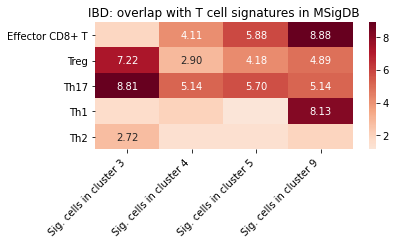

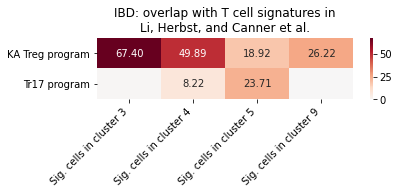

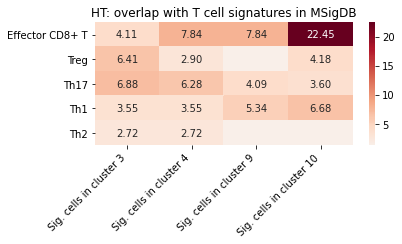

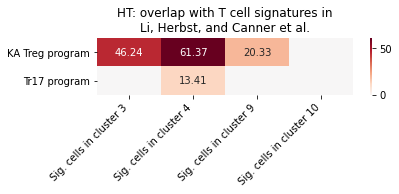

In [20]:
# Overlap with signatures
temp_df = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/tcell_signature_full.gs', 
                      sep='\t', index_col=0)
df_sig = temp_df.loc[['effector_cd8', 'SUBTYPE_Treg', 'SUBTYPE_Th1', 'SUBTYPE_Th2', 'SUBTYPE_Th17']].copy()
for gs in df_sig.index:
    df_sig.loc[gs, 'GENESET'] = set([DIC_MAP_H2M[x] 
                                     for x in df_sig.loc[gs, 'GENESET'].split(',') if x in DIC_MAP_H2M])

    
temp_df = pd.read_excel('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation'
                        '/Li_CR_2019_tabs2.xlsx', sheet_name='Treg Pagoda modules', skiprows=1)
df_sig.loc['KA_TR_Li', 'GENESET'] = (set(temp_df['Module 12']) | set(temp_df['Module 21'])) - {np.nan}
df_sig.loc['Tr17_Li', 'GENESET'] = set(temp_df['Module 13']) - {np.nan}

# # Save Li et al. gene sets
# temp_df = df_sig.loc[['KA_TR_Li', 'Tr17_Li']].copy()
# temp_df['GENESET'] = [','.join(sorted(x)) for x in temp_df['GENESET']]
# temp_df.to_csv(DATA_PATH+'/supp_table.rv1/Li_et_al_Treg_program.tsv', sep='\t')

# Compute overlap
dic_stats = {}
for trait in trait_list:
    # Compute stats     
    background_set = set(dic_data_annot[trait].var_names)
    dic_stats[trait] = pd.DataFrame(index=df_sig.index, columns=dic_top_group[trait], data=0)
    for sig in df_sig.index:
        gs_sig = df_sig.loc[sig, 'GENESET']
        for group in dic_top_group[trait]:
            df_gene = sc.get.rank_genes_groups_df(dic_data_annot[trait], group=group)
            gs = set(df_gene['names'][:300])
            pvalue,oddsratio,or_ub,or_lb = scdrs.util.test_overlap(gs, gs_sig, background_set)
            dic_stats[trait].loc[sig, group] = pvalue

    # Make figure: MSigDB signatures 
    plot_list = ['effector_cd8', 'SUBTYPE_Treg', 'SUBTYPE_Th17', 'SUBTYPE_Th1', 'SUBTYPE_Th2']
    plot_name = ['Effector CD8+ T', 'Treg', 'Th17', 'Th1', 'Th2']
    df_plot = -np.log10(dic_stats[trait].loc[plot_list].copy())
    df_plot.index = plot_name
    df_plot.columns = ['Sig. cells in cluster %s'%x.split('.')[0] for x in df_plot.columns]
    df_annot = df_plot.copy()
    threshold = -np.log10(0.05/df_plot.shape[0]/df_plot.shape[1])
    for col in df_annot:
        df_annot[col] = ['%0.2f'%x if x>threshold else '' for x in df_annot[col]]
    plt.figure(figsize=[6,3.5])
    sns.heatmap(df_plot, annot=df_annot, fmt='s', cmap='RdBu_r', center=0)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.ylabel('')
    plt.title('%s: overlap with T cell signatures in MSigDB'%DF_TRAIT_INFO.loc[trait, 'Code'])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc.%s_overlap_dsigdb.svg'%DF_TRAIT_INFO.loc[trait, 'Code'])
    plt.show()

    # Make figure: Li et al signatures 
    plot_list = ['KA_TR_Li', 'Tr17_Li']
    plot_name = ['KA Treg program', 'Tr17 program']
    df_plot = -np.log10(dic_stats[trait].loc[plot_list].copy())
    df_plot.index = plot_name
    df_plot.columns = ['Sig. cells in cluster %s'%x.split('.')[0] for x in df_plot.columns]
    df_annot = df_plot.copy()
    threshold = -np.log10(0.05/df_plot.shape[0]/df_plot.shape[1])
    for col in df_annot:
        df_annot[col] = ['%0.2f'%x if x>threshold else '' for x in df_annot[col]]
    plt.figure(figsize=[6,2.8])
    sns.heatmap(df_plot, annot=df_annot, fmt='s', cmap='RdBu_r', center=0)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.ylabel('')
    plt.title('%s: overlap with T cell signatures in\nLi, Herbst, and Canner et al.'
              %DF_TRAIT_INFO.loc[trait, 'Code'])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc.%s_overlap_Li.svg'%DF_TRAIT_INFO.loc[trait, 'Code'])
    plt.show()

### Annotating associated cells : check if significant cells in each cluster are random 

In [21]:
# Is the selection in each cluster random?    
for trait in trait_list:
    df_stats = pd.DataFrame(index=dic_top_group[trait], columns=['C', 'pval'], dtype=float)
    
    if trait == 'PASS_IBD_deLange2017':
        df_stats['C'] = [0.78286691, 0.7444599, 0.79507505, 0.8922842]
        df_stats['pval'] = [0.000999001, 0.008991009, 0.005994006, 0.075924076]
    if trait == 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP':
        df_stats['C'] = [0.68524429, 0.64980309, 0.77004084, 0.82216174]
        df_stats['pval'] = [0.000999  , 0.002997  , 0.000999  , 0.12187812]

    n_ctrl = 1000 
#     for cluster in df_stats.index: 
#         print(cluster)
#         ind_select = dic_data_proc[ds].obs['leiden_reorder']==int(cluster.split('.')[0])
#         temp_adata = dic_data_proc[ds][ind_select, :].copy()
#         temp_df = dic_ctrl_score[ds][trait].loc[temp_adata.obs_names].copy()
#         c_ = scdrs.method.gearys_c(temp_adata, dic_score[ds].loc[temp_adata.obs_names, '%s.norm_score'%trait])
#         v_c_ctrl = np.zeros(n_ctrl)
#         for i_ctrl in range(n_ctrl):
#             v_c_ctrl[i_ctrl] = scdrs.method.gearys_c(temp_adata, temp_df['ctrl_norm_score_%d'%i_ctrl])
#         df_stats.loc[cluster] = [c_, (np.sum(c_>=v_c_ctrl)+1)/(n_ctrl+1)]

    df_stats['pval_str_num'] = [scdrs.util.p_2_str_num(x,n_ctrl) for x in df_stats['pval']]
    print(trait)
    display(df_stats)

PASS_IBD_deLange2017


C      pval pval_str_num
3.sig  0.782867  0.000999      P<0.001
4.sig  0.744460  0.008991      P=0.009
5.sig  0.795075  0.005994      P=0.006
9.sig  0.892284  0.075924      P=0.076

UKB_460K.disease_HYPOTHYROIDISM_SELF_REP


C      pval pval_str_num
3.sig   0.685244  0.000999      P<0.001
4.sig   0.649803  0.002997      P=0.003
9.sig   0.770041  0.000999      P<0.001
10.sig  0.822162  0.121878      P=0.122

### Annotating associated cells : pathway analysis 

In [22]:
dic_pathway = {x:{} for x in trait_list}
dic_pw_list = {x:[] for x in trait_list}

for trait in trait_list:
    # Get SEGs 
    temp_adata = dic_data_annot[trait].copy()
    temp_adata.obs['leiden_sig_new'] = [
        '%s.nonsig'%y if x=='nonsig' else x 
        for x,y in zip(temp_adata.obs['leiden_sig.%s'%trait], temp_adata.obs['leiden_reorder'])] 
    group_list = dic_top_group[trait] + [x.replace('sig','nonsig') for x in dic_top_group[trait]]
    sc.tl.rank_genes_groups(temp_adata, groupby='leiden_sig_new', groups=group_list)
    
    # Pathway: enrichr    
    for group in group_list:
        df_gene = sc.get.rank_genes_groups_df(temp_adata, group=group)
        gene_list = list(df_gene['names'][:300])
        res = gp.enrichr(gene_list=gene_list, description='pathway',
                         gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018', 'Reactome_2016'],
                         organism='Mouse', outdir=None)
        
        df_pathway = res.results
        df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
        df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
        df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
        df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
        dic_pathway[trait][group] = df_pathway.copy()
        
        ind_select = (df_pathway['Intersect']>10) & (df_pathway['Recall']>0.10) & (df_pathway['Term_size']<500) 
        dic_pw_list[trait].extend(df_pathway.loc[ind_select, 'Term'])

    for group in group_list:
        dic_pathway[trait][group].index = dic_pathway[trait][group]['Term']
        dic_pathway[trait][group] = dic_pathway[trait][group].loc[
            set(dic_pathway[trait][group].index) & set(dic_pw_list[trait])]
    del temp_adata

... storing 'leiden_sig_new' as categorical


... storing 'leiden_sig_new' as categorical


PASS_IBD_deLange2017 3.sig


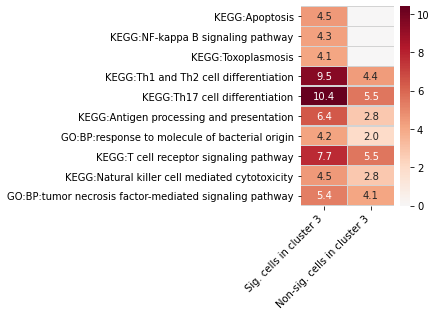

PASS_IBD_deLange2017 4.sig


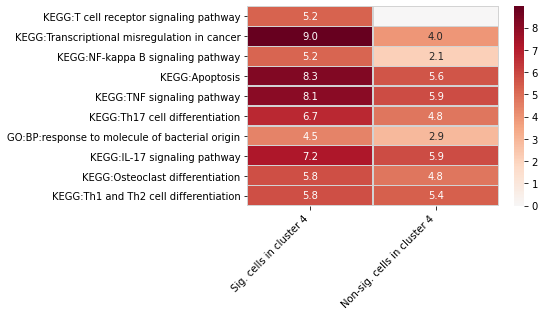

PASS_IBD_deLange2017 5.sig


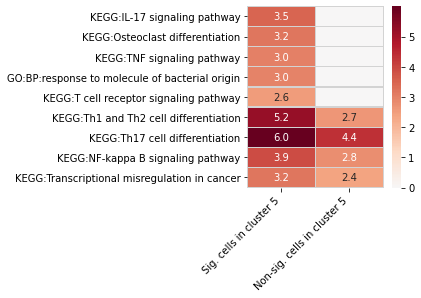

PASS_IBD_deLange2017 9.sig


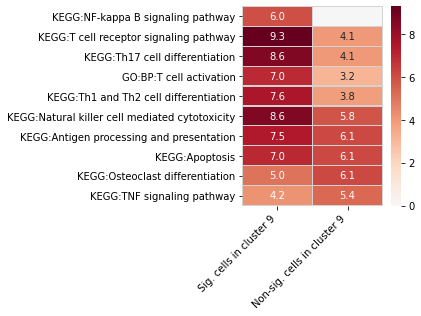

UKB_460K.disease_HYPOTHYROIDISM_SELF_REP 3.sig


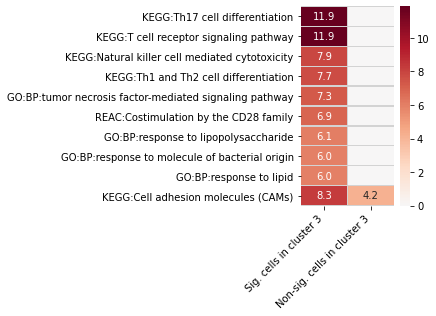

UKB_460K.disease_HYPOTHYROIDISM_SELF_REP 4.sig


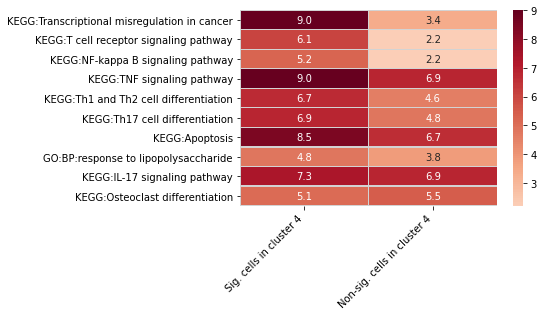

UKB_460K.disease_HYPOTHYROIDISM_SELF_REP 9.sig


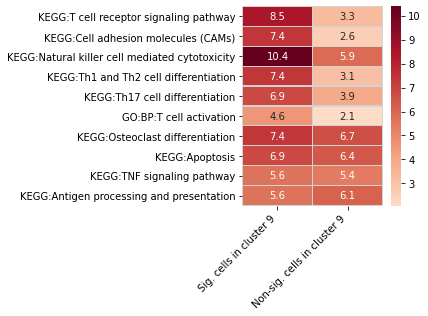

UKB_460K.disease_HYPOTHYROIDISM_SELF_REP 10.sig


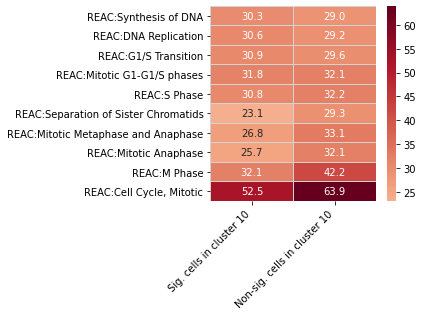

In [23]:
dic_source = {'KEGG_2019_Mouse':'KEGG', 'GO_Biological_Process_2018':'GO:BP', 'Reactome_2016':'REAC'}
for trait in trait_list:
    for cluster in dic_top_group[trait]:
        print(trait, cluster)
        df_plot = pd.DataFrame()
        for group in [cluster, cluster.replace('sig', 'nonsig')]:
            temp_df = dic_pathway[trait][group][['Adjusted P-value']]
            temp_df.index = ['%s:%s'%(dic_source[x],y.split(' (GO')[0].split(' Homo')[0]) 
                             for x,y in zip(dic_pathway[trait][group]['Gene_set'],
                                            dic_pathway[trait][group]['Term'])]
            temp_df.columns = [group]
            df_plot = df_plot.join(temp_df, how='outer')

        df_plot.fillna(1, inplace=True)
        df_plot = -np.log10(df_plot)
        df_plot['max'] = df_plot.max(axis=1)
        df_plot['dif'] = df_plot.iloc[:,0] - df_plot.iloc[:,1]+10*(df_plot.iloc[:,1]==0)
        df_plot = df_plot.sort_values(by='max', ascending=False, inplace=False).iloc[:10]
        df_plot.sort_values(by='dif', ascending=False, inplace=True)
        df_plot.index.name = ''
        df_plot = df_plot[[cluster, cluster.replace('sig', 'nonsig')]]
        df_plot.columns = ['Sig. cells in cluster %s'%cluster.split('.')[0],
                           'Non-sig. cells in cluster %s'%cluster.split('.')[0],]
        df_annot = df_plot.copy()
        for col in df_annot.columns:
            df_annot[col] = ['%0.1f'%x if x>0.1 else '' for x in df_annot[col]]

        if df_plot.shape[0]==0:
            continue
            
        plt.figure(figsize=[6+2*(cluster=='4.sig'), 2+0.25*df_plot.shape[0]])
        sns.heatmap(df_plot, cmap='RdBu_r', annot=df_annot,
                    fmt='s', center=0, linewidths=0.2, linecolor='lightgrey')
        plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(FIG_PATH+'/%s_pathway.%s.svg'%(DF_TRAIT_INFO.loc[trait, 'Code'], cluster))
        plt.show()

### CD4/CD8 effector gradients

dpt_cd4_qn n_cell=1686, clusters=1,2,3,4


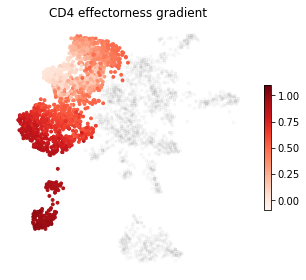

dpt_cd8_qn n_cell=2197, clusters=1,2,7,8,9


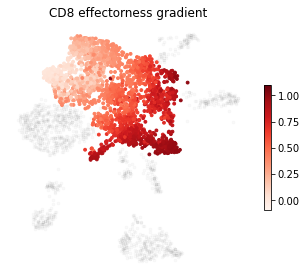

In [24]:
# Pseudotime: make it nicer later 
ds='tms_facs'
adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
dic_title = {'dpt_cd4_qn': 'CD4 effectorness gradient', 'facs_cd4': 'CD4 effectorness gradient',
             'dpt_cd8_qn': 'CD8 effectorness gradient', 'facs_cd8': 'CD8 effectorness gradient'}
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['dpt_cd4_qn', 'dpt_cd8_qn', 'leiden_reorder']])

for term in ['dpt_cd4_qn', 'dpt_cd8_qn']:    
    plt.figure(figsize=[4.5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    ind_select = df_plot[term]>=0
    print('%s n_cell=%d, clusters=%s'%(term, ind_select.sum(), 
                                       ','.join([str(x) for x in sorted(set(df_plot.loc[ind_select,
                                                                                        'leiden_reorder']))])))
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', alpha=0.025, s=8)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, term], cmap='Reds', vmax=1.1, vmin=-0.1, s=8)
    plt.colorbar(shrink=0.5)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(dic_title[term])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/%s.svg'%term)
    plt.savefig(FIG_PATH+'/%s.png'%term)
    plt.show()

In [25]:
# Prepare regression datasets 
n_ctrl = 1000 
dic_cov = {}

# FACS CD4 
dic_cov['facs_cd4'] = dic_data_proc['tms_facs'].obs.copy()
dic_cov['facs_cd4']['effectorness'] = dic_cov['facs_cd4']['dpt_cd4_qn']
dic_cov['facs_cd4'] = dic_cov['facs_cd4'].loc[dic_cov['facs_cd4']['effectorness']>0].copy()

# FACS CD8 
dic_cov['facs_cd8'] = dic_data_proc['tms_facs'].obs.copy()
dic_cov['facs_cd8']['effectorness'] = dic_cov['facs_cd8']['dpt_cd8_qn']
dic_cov['facs_cd8'] = dic_cov['facs_cd8'].loc[dic_cov['facs_cd8']['effectorness']>0].copy()

# Add const and leiden
for cov_name in dic_cov:
    dic_cov[cov_name]['const'] = 1
    for cluster in set(dic_cov[cov_name]['leiden_reorder']):
        if (dic_cov[cov_name]['leiden_reorder']==cluster).sum()>0:
            dic_cov[cov_name]['leidenreg_%d'%cluster] = (dic_cov[cov_name]['leiden_reorder']==cluster)*1

In [26]:
# Regression analysis
dic_reg = {'reg_marginal': ['effectorness'],
           'reg_joint': ['effectorness', 'leidenreg']
          }

dic_stats = {}
for cov_name in dic_cov:
    for reg_name in dic_reg:
        print(cov_name, reg_name)
        reg_list = dic_reg[reg_name].copy()
        if 'leidenreg' in reg_list:
            reg_list.remove('leidenreg')
            ctrl_list = ['const'] + [x for x in dic_cov[cov_name].columns if 'leidenreg' in x]
        else:
            ctrl_list = ['const']
        df_stats = pd.DataFrame(columns=['var_ctrl','var']+['%s.%s'%(y,x) for x in reg_list for y in ['T', 'P']])
        ds = cov_name.split('_' )[0]
        
        for score in ['tms_facs', 'tms_facs.tsig']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    print('Missing', score, '%s.norm_score'%trait)
                    continue              

                df_reg = dic_cov[cov_name][reg_list+ctrl_list].copy()
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list]).fit()
                var_explain_ctrl_ = 1 - res.mse_resid/res.mse_total

                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list+reg_list]).fit()
                var_explain_ = 1 - res.mse_resid/res.mse_total
                dic_t = {x:res.tvalues[x] for x in reg_list}
                dic_t_ctrl = {x:np.zeros(n_ctrl) for x in reg_list}

                for i in range(n_ctrl):
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i], df_reg[ctrl_list+reg_list]).fit()
                    for reg in reg_list:
                        dic_t_ctrl[reg][i] = res.tvalues[reg]
                if trait in ['naive_cd4', 'naive_cd8']:
                    dic_p = {x:((dic_t[x] >= dic_t_ctrl[x]).sum()+1) / (n_ctrl+1) for x in reg_list} 
                else:
                    dic_p = {x:((dic_t[x] <= dic_t_ctrl[x]).sum()+1) / (n_ctrl+1) for x in reg_list} 
                df_stats.loc[trait] = [var_explain_ctrl_, var_explain_] + \
                    [y[x] for x in reg_list for y in [dic_t, dic_p]]

        for reg_term in reg_list:
            df_stats['P_STR.%s'%reg_term] = [scdrs.util.p_2_str(x) for x in df_stats['P.%s'%reg_term]]
            df_stats['P_STR_NUM.%s'%reg_term] = [scdrs.util.p_2_str_num(x,n_ctrl) for x in df_stats['P.%s'%reg_term]]
        dic_stats['%s.%s'%(cov_name, reg_name)] = df_stats

facs_cd4 reg_marginal
facs_cd4 reg_joint
facs_cd8 reg_marginal
facs_cd8 reg_joint


In [27]:
# Output table: Association p-values
trait_list = DIC_TRAIT_LIST['tms_facs'].copy()
df_res = pd.DataFrame(index=trait_list)
df_res['Trait'] = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_res.index]

for cov_name in dic_cov:
    term = 'CD4' if cov_name=='facs_cd4' else 'CD8'
    # Marginal regression
    temp_df = dic_stats['%s.reg_marginal'%(cov_name)][['P.effectorness', 'var']].copy()
    temp_df.columns = ['%s.P'%term, '%s.Var'%term]
    df_res = df_res.join(temp_df)
    
    # Joint regression 
    temp_df = dic_stats['%s.reg_joint'%(cov_name)][['var_ctrl', 'var', 'P.effectorness']]
    temp_df.columns = ['%s.Var.cluster'%term, '%s.Var.joint'%term, '%s.P.joint'%term]
    df_res = df_res.join(temp_df)
    
df_res = df_res[['Trait', 'CD4.P', 'CD4.Var', 'CD4.P.joint', 'CD8.P', 'CD8.Var', 'CD8.P.joint', ]]
for col in ['CD4.P', 'CD4.P.joint', 'CD8.P', 'CD8.P.joint']:
    df_res[col] = ['$\textbf{%0.3f}$'%x if x<0.005 else '$%0.3f$'%x for x in df_res[col]]
for col in ['CD4.Var', 'CD8.Var']:
    df_res[col] = ['%0.3f'%x for x in df_res[col]]
print(df_res.to_latex(index=False, escape=False, column_format='|c|cc|c|cc|c|'))

\begin{tabular}{|c|cc|c|cc|c|}
\toprule
  Trait &             CD4.P & CD4.Var &       CD4.P.joint &    CD8.P & CD8.Var & CD8.P.joint \\
\midrule
    IBD &  $\textbf{0.001}$ &   0.282 &  $\textbf{0.005}$ &  $0.021$ &   0.083 &     $0.022$ \\
     CD &  $\textbf{0.001}$ &   0.202 &  $\textbf{0.004}$ &  $0.026$ &   0.087 &     $0.006$ \\
     UC &  $\textbf{0.004}$ &   0.159 &           $0.069$ &  $0.441$ &  -0.000 &     $0.545$ \\
     RA &           $0.118$ &   0.024 &           $0.269$ &  $0.261$ &   0.006 &     $0.568$ \\
     MS &           $0.223$ &   0.009 &           $0.239$ &  $0.129$ &   0.020 &     $0.420$ \\
    AIT &  $\textbf{0.002}$ &   0.188 &           $0.007$ &  $0.038$ &   0.064 &     $0.193$ \\
     HT &  $\textbf{0.003}$ &   0.153 &           $0.034$ &  $0.100$ &   0.028 &     $0.265$ \\
 Eczema &           $0.011$ &   0.087 &           $0.250$ &  $0.819$ &   0.016 &     $0.889$ \\
    ASM &           $0.035$ &   0.059 &           $0.387$ &  $0.325$ &   0.001 &     $0

facs_cd4 ['naive_cd4', 'memory_cd4', 'effector_cd4'] (1685, 33)


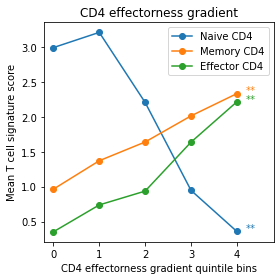

facs_cd8 ['naive_cd8', 'memory_cd8', 'effector_cd8'] (2196, 34)


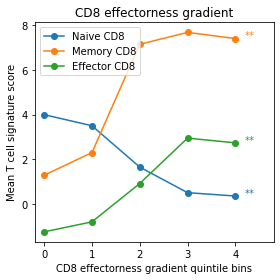

In [28]:
# T cell signatures
score = 'tms_facs.tsig'
plot_list = [['facs_cd4', ['naive_cd4', 'memory_cd4', 'effector_cd4']],
             ['facs_cd8', ['naive_cd8', 'memory_cd8', 'effector_cd8']] ]

for cov_name,trait_list in plot_list:
    df_plot = dic_cov[cov_name].copy()
    df_plot = df_plot.join(dic_score[score][['%s.norm_score'%x for x in trait_list]])
    df_plot['bin'] = pd.qcut(df_plot['effectorness'], q=5, labels=False)
    print(cov_name, trait_list, df_plot.shape)
    
    plt.figure(figsize=[4,4])
    i_color = 0
    for trait in trait_list:
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%trait], 'o-', 
                 label=DF_TRAIT_INFO.loc[trait, 'Code'], color='C%d'%i_color)
        plt.text(4.2, temp_df['%s.norm_score'%trait][4], 
                 dic_stats['%s.reg_marginal'%cov_name].loc[trait,'P_STR.effectorness'],
                 color='C%d'%i_color)
        i_color+=1    
    plt.xlim([-0.2,4.8])
    plt.legend()
    plt.xlabel('%s quintile bins'%dic_title[cov_name])
    plt.ylabel('Mean T cell signature score')
    plt.title(dic_title[cov_name])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_tsig_corr.%s.svg'%cov_name)
    plt.show()
    

facs_cd4 ['UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 'PASS_IBD_deLange2017', 'UKB_460K.body_HEIGHTz'] (1685, 36)


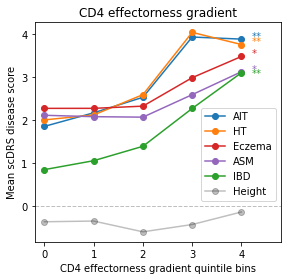

facs_cd8 ['UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 'PASS_IBD_deLange2017', 'UKB_460K.body_HEIGHTz'] (2196, 37)


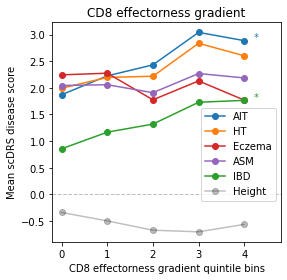

In [29]:
# Traits
score = 'tms_facs'
trait_list = [
    'UKB_460K.disease_AID_ALL',
    'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 
    'UKB_460K.disease_ASTHMA_DIAGNOSED',
    'PASS_IBD_deLange2017',  
    'UKB_460K.body_HEIGHTz'
             ]
dic_config_trait = {
    'UKB_460K.disease_AID_ALL': ['C0'], 
    'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP': ['C1'], 
    'PASS_IBD_deLange2017': ['C2'], 
    'PASS_CD_deLange2017': ['C8'], 
    'PASS_UC_deLange2017': ['C9'], 
    'PASS_Rheumatoid_Arthritis': ['C5'],
    'UKB_460K.disease_RESPIRATORY_ENT' : ['C6'],
    'UKB_460K.disease_ASTHMA_DIAGNOSED' : ['C4'],
    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED' : ['C3'],
    'PASS_Multiple_sclerosis' : ['C7'],
    'UKB_460K.body_HEIGHTz' : ['k']
                   }

for cov_name in ['facs_cd4', 'facs_cd8']:
    df_plot = dic_cov[cov_name].copy()
    df_plot = df_plot.join(dic_score[score][['%s.norm_score'%x for x in trait_list]])
    df_plot['bin'] = pd.qcut(df_plot['effectorness'], q=5, labels=False)
    print(cov_name, trait_list, df_plot.shape)
    
    plt.figure(figsize=[4.1,4])
    i_color = 0
    y_text = 5
    for trait in trait_list:
        alpha_=0.25 if trait=='UKB_460K.body_HEIGHTz' else 1
#         color_='k' if trait=='UKB_460K.body_HEIGHTz' else 'C%d'%i_color
        color_=dic_config_trait[trait][0]
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%trait], 'o-', 
                 label=DF_TRAIT_INFO.loc[trait, 'Code'], color=color_, alpha=alpha_)
        if cov_name=='facs_cd4':
            y_text = min(y_text-0.1, temp_df['%s.norm_score'%trait][4])
        else:
            y_text = temp_df['%s.norm_score'%trait][4]
        plt.text(4.2, y_text, dic_stats['%s.reg_marginal'%cov_name].loc[trait,'P_STR.effectorness'], 
                 color=color_, alpha=alpha_)
        i_color+=1
    plt.axhline(y=0, ls="--", color="k", lw=1, alpha=0.25)
    plt.xlim([-0.2,4.8])
    plt.legend(loc='center right', bbox_to_anchor=[1,0.4])
    plt.xlabel('%s quintile bins'%dic_title[cov_name])
    plt.ylabel('Mean scDRS disease score')
    plt.title(dic_title[cov_name])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_trait_corr.%s.svg'%cov_name)
    plt.show()
#     break